# lesson 6 configure azure sql db for scale and performance

**note:backup storage redundancy** 

geo redundant backup will replicate the storage to a paired region (e.g. US East to Us West) in case of data storage damaging

**note:billing type** 
- provisional charged based on vcore
- serverless charged based on second, shut down after 1 hr inactivity, restarted takes a little time


**note:hybrid benefit** 
- it's a Microsoft licensing program that allows customers to use their existing on-premises Windows Server and SQL Server licenses with active Software Assurance or subscription to reduce costs when running those workloads in Azure
- can only work with vcore, not with dtu

**note:elastic pool** 

- let manage multiple db resource allocation possible, so they could share resource when one not using it
- not possible for hyperscale
- can select edtu (elastic dtu) in setting
- unit price for edut compared to dtu is extra 50 %, vcore have same unti price
- vcore llows independently select compute and storage resources. The DTU model is a bundled measure of compute, storage, and I/O resources.
- if a DTU db peak at different time, elastic pool could be a good idea, otherwise it's more expensive due to unit price
- unavailable at hyperscale




### storage purchasing model
- can be changed later, except changed out of hyperscale
- change should be done at a low trafic time
- after change DMV(dynamic management view) needed to be flushed for accurate estimation
exec sq_query_store_flush
##### DTU (database transaction unit)based
- DTU can be adjusted with related S tier
- CDC (changed data captured) can't be used when having less than 100 DTB (= S3 = 1vcore)
- when using more than 300 DTU, vcore might be a cheaper option
- plan selection can based on peak usage and storage need, the latter could be estimate with average data use * db number 
1. Basic: up to 2GB
Development, testing, infrequently accessed workload
2. Standard
3. Premium
suitable when more iops (inputs output per second) is needed
##### vCore (virtual core) based
- max data storgae and core could be specified
- core decide max data storgae ceiling & tempdb size
- log space is 30% of the max data stoarge
- hardware choice affect memory, core number and storage
- iops = concurrent number of request, this can't be configured, but go up with vcore
- mi have only vcore no dtu
4. general purpose: 80 vcore, 4 terabyte storage
    - suitable for low latency input
    - it  has a zone-redundant configuration with two layers: a stateful data layer and a stateless compute layer. This tier includes databases with synchronous copies across three physically isolated Azure availability zones.
    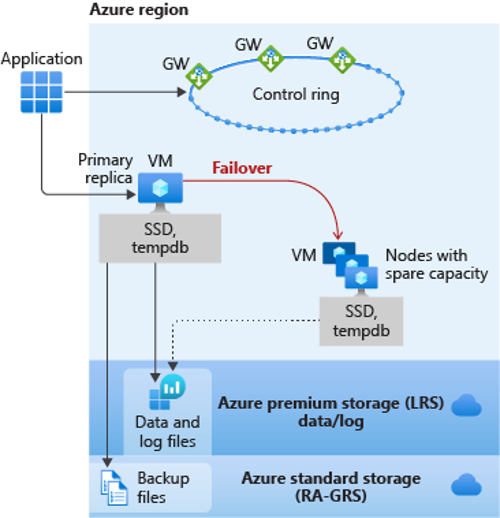
5. Hyperscale: 80 vcore, 100 terabyte storage
    - before Hyperscale, Azure SQL Database has been limited to 4 TB of storage per database for many year

    - Hyperscale does not support:


        1. Elastic Pools

        2. Geo-replication

        3. Query Performance Insights: a feature that provides performance monitoring and tuning recommendations for your Azure SQL Database.
    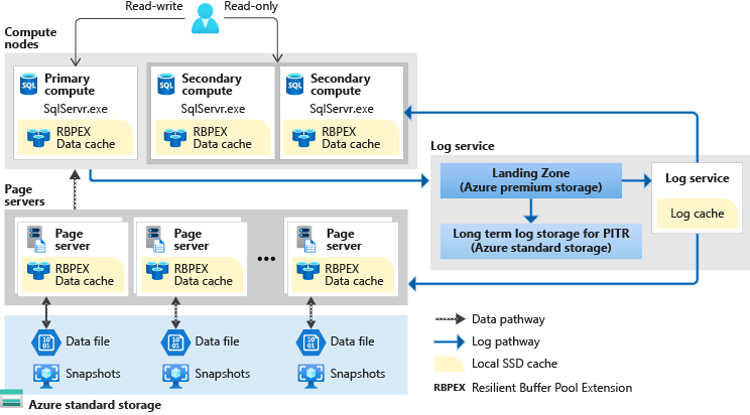
6. Business critical: 80 vcore, 4 terabyte storage, 
    - fast geo-recovery and advanced data corruption protection, free second read-only replica
    - Business critical has high transaction rate and high resiliency, is suitable for large number/long-running transaction
    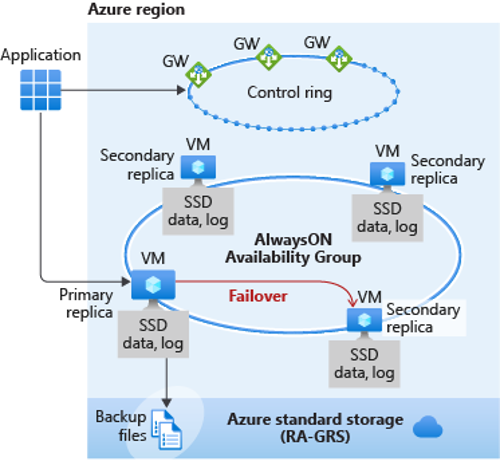
- default for Compute + storage for Azure sql db is  Gen5, 2vCore, with 32 GB of storage

**note**: While Hyperscale shares a name with Azure SQL Database and while they both offer horizontal scalability supporting very large data volumes, the Hyperscale technology for PostgreSQL is implemented in a shared nothing architecture. In a shared nothing architecture, each node in the system is independent and does not share memory or disk storage with other nodes, which allows for better scalability and performance.

Hyperscale databases are sharded, which means that the data in a single table can be split across multiple nodes, using a type of table called a distributed table. This sharding allows for both parallelization and distribution of queries across nodes. The worker nodes and coordinator nodes can be scaled independently of each other.


### table partitioning

- a table have 3 elements storage space, computing resource limit (exceeing might lead to timeout) and network bandwidth limit
- vertical scaling by adding disc space, processing power, memory and network connection could be a short term solution
- horizontal scaling by divifing the table up according to rule e.g. by year, it add up complexity but reduce hardware demand
- back up per partition is also faster 
- the other option is to split the table columns up

### database  sharding
- when we apply horizontal scaling on db level
- there would be a table with shard key, and where they are stored, this require more setting up 
- range strategy is diving by range e.g.years, sequential shard, data might be unblanced when there is seasonality
- hashing strategy introduce random element for distribution, it reduce hotspot bcs no cluster would be more used, but rebalancing and manging mmight be difficult, when looking up a value the results are all over places
- functional partitioning, not putting all the tables in the same db, e.g. seperate tables that needs extra security
- keeping data geographically close can reduce latency when using

**note: file group**
- can't be used in Azure SQL db (only primary file group there)
- file can be putted in file group to define partition range rules and where to store

### compression for table
- pro 
    - Each index or table can be compressed individually.
    -  reduce the amount of physical I/O performed, as more rows of data can be stored on a given page
    - It allows more rows to be stored in the buffer pool, making more efficient use of memory.
- con 
    - it requires additional CPU resources to compress and decompress the data
- can't be used on table with sparse columns
- changing compression require droping clustered index
- complete index viewed can be compressed
- system table can't be compressed
- table with different partition can be compressed differently
- *exec sp_estimate_data_compression_savings* help estimate compression effect
- allows more rows of data to be stored on a given page, which means that when querying the data, fewer pages need to be read from disk. This results in reduced physical IO operations and faster query performance.
method:
1. no compression
2. row compression: char and nchar columns would be greatly reduced, varchar and int not so much, date types depends, tiny int not at all
3. page compression which includes (below element can't be activated seperately):
    1. row compression
    2. prefix compression: store long duplicated value in a specific column as prefix key, and generate an extra table for prefix key to long name to prevent the duplication of long char storage
    3. dictionary compression: similar to prefix compression, but instead of on a specific column, the duplication would be searched across columns and keys would be used for whole table

    - page is a set of row up to 8192 character
    - uncompressed at first, when additional rows can't be fit in, compression takes place
    - some older version SQL server on VM is this unavailable
4. Columnstore Archival compression 
    - offers the highest level of compression by storing data in columnar format, which allows for significant reduction in storage space
    - This is particularly effective for large datasets with repetitive values.

**note heap**
haep is table without clustered index

**columnstore table**
above are row stored table. in columnstore table, columns are always compress, which could be further compressed through columnstore archival compression (but this has super high compute cost for uncompress)

Row and page compression can be not used for columstore tables.



### SQL data sync
- works for Azure SQL, on-prem or VM, but not with management instance
- allows sync across db
- primary key is required
- must define a hub db and multiple member dbs
- rules can be defined which direction to sync, e.g. change would be replicated from hub to member or member to hub, but not directly between members
- rule when hub and member simultaneously changed should be defined
- sync metadata db is an azure sql db whihc loacte in the same region as hub and store, should be empty at start
- for on perm or vm member db, a sync agent programm is needed 
- on azure db page syncing db could be created


# lesson 7 strategy of migration 

### migration tools

| purpose    | tool | extra function |
| -------- | ------- | ------- |
| lift & shift sql server to vm   | azure migrate    |   assess sql data estate at scale(across data center)/getting azure sql deployment recommendation, target sizing & monthly estimate  |
| non sql objects (DB2, MYSQL, Oracle, SAP, ASE) to sql/azure sql, each are independent download program | sql server migration system     ||
| sql server object to sql db/managed instance/vm/on prem     | data migration system    |upgrade SQL/assess sql data estate at scale/ performance & reliability improvement recommendation/ detect incompatibility of target/ migrate on-prime/ discover new feature on target|
| compare workloads between source and target  | database experiementation assistant    | |
| open source db (mysql, postgresql, mariadb) to azure offline/online (premium price tier)  | azure db migration service    ||
| providing intelligent assessments and recommendations for Azure services | Intelligent Assessment Advisor and Migration Toolkit  |  is an older, now-deprecated, on-premises tool|
|  used in the discovery stage of migration, It helps confirm the source environment that you are migrating from by providing insights and recommendations for a successful migration process.  | Microsoft Planning and Assessment   ||
1. azure migrate  
- consists of 2 tools: discovery & assessment, server migration
**azure migrant hub** includes azure migration assistant & azure db migration service

2. sql server migration system 

3. data migration system
- for large size data azure db migration service  would be better option

4. database experiementation assistant 

5. azure db migration service 
- princing tier standard provides up to 4 vcore for free, but only support offline migration
- princing tier premium provides up to 4 vcore with 6 month free trial, support offline & online

| from    | to | online (continuous sync)    | offline (one-time) |
| -------- | ------- | -------- | ------- 
| SQL server  | azure sql db    | v  | v    |
| SQL server    | azure sql db mi    | v | v    |
| SQL server    | azure sql vm  | x  | v    |
| mongodb    | azure cosmos db  | v | v    |
| mySQL    | azure db for mySQL  | x  | v   |
| postgreSQL/MySQL    | azure db for postgresql/MySQL  | v  | x  |




**reminder** if not latest SQL is needed, then VM must be used and a window version needed to be decide

**note** 
- without downtime allowance, the only way is to do an online migration
- if cross db dependecy exist, azure db is not a good option, as it doesn't allow cross db queries
- for azure db migration service, allow outbond port 443 = port for https or 1434 used for UDP, then enable TCP IP protocal, next create azure SQL db instance which needs a server level firewall rule on depature db/server & contorl server permission on depature server to allow access to DMS and on target db control db permission is needed. it use exsiting full log backup instead of creating new one
- there are other service e.g. Bulk copie programm, command bulk insert, log data from Azure blob storage, SQL server integration service package, spark/azure factory
**note**  The minimum number of rows required to perform a bulk insert into a columnstore index is 102,400.
- migrant stuff directly between Azure SQL db can use export or export data tier application (which allow export of schema), or export form azure portal, download and using SQLpackage
- export data tier application (DAC) will make the export as .bacpac (backup package) file

### post migration
1. have tests to make sure data are there
2. checking Query returns same result in sourece and target db
3. checking the performance
4. changing the app connecting to db from departure db to target db
5. checking missin features

# lesson 8 Microsoft Entra ID


### authn = authentication = log in
1. window authentication
    - on a window machine/domain 
    - in azure only on VM is window available
2. SQL sever authentication
    - using username and password
    - most suitable authentication method for an older application that cannot change the driver or connection string on a non-Azure machine
    - allows the application to authenticate using credentials directly provided in the connection string without relying on integrated or managed identities
3. azure active directory
    - setting could be access through azure portal, e.g. adding user
    - more secure than SQL sever authentication and can select way to authenticate in portal 
    - once the AAD admin is setted through azure portal (only 1 admin allow), the admin can log in SSMS through (other log in method won't allow role creation) and create more roles through query 
    - comparison between AAD admin and sql server admin:
        - both could create users based on SQL server authentication log in
        - both can create contained DB users based on SQL server authentication wo log in
        - AAD admin can create contained DB users based on aad users and group
    - authentication methods includes FIDO secutity keys which is a hardware on computer, microsoft authenticator, text message and temporary access pass
    - can sync with on-prem windows server active directory
    - when we are logging in azure portal is a form of azure active directory
    - azure active directory - integrated/universal with MFA(multi factor authentication) can be used when using admin tool like SSMS on a computer that is not domain joined
    - for connecting to the server admin is integrated(window auth)/MFA(multiple forms of verification)/ password possible
    - 3 different way to authenticate in:
        1. cloud only identity
            - handle sign in completely in cloud by azure
        2. federated authentication
            - integrate with existing federation provider
            - sign in requirement which is not native supported by Azure active directory
        3. pass-through authentication
            - when don't have a sign-in requirement not natively supported by Azure active directory
            - and want to enforce extra feature like user level active directory sign in policy
    - identity: 
        1. cloud only identity
        2. hybrid identity support both cloud authentication & pass-through authentication
        3. hybrid identity support federated authentication
    - to create a user based on AAD user use: create user [user_email] from external provider
4. window server active directory

5. Microsoft Entra ID authentication with integrated authentication 
    - would be the most suitable choice for the application on a non-Azure machine that is domain-joined or  for applications running on-premises or in a hybrid environment, where the application can authenticate using the user's Windows credentials.
    - allows seamless authentication using the user's existing domain credentials without the need to hard-code passwords or secrets in connection strings or app configuration files
    **note** hybrid refers to a solution that combines resources both in Azure and on-premises or in another cloud provider. 

6. Microsoft Entra ID authentication: client ID/certificate.
    -  more commonly used for service-to-service authentication or for applications that require client credentials to access Azure resources,

7.  Microsoft Entra ID authentication: Managed identity
    - typically used for Azure resources to authenticate with other Azure resources and services
    -  a secure way for applications running on Azure VMs to access Azure resources using the VM's identity without needing to store credentials in the application code or configuration files. 

8. Microsoft Entra ID authentication:  interactive and multifactor authentication 
    - more suitable for interactive user authentication scenarios, such as signing in to Azure portals or applications

**note:**
- authz = autherization = what one could access

- Microsoft Entra ID Connect can be used to synchronize on-premises Microsoft Entra ID, including syncing user accounts, passwords, and groups. This synchronization allows for a seamless integration between on-premises Microsoft Entra ID and cloud.

- On-prem SQL Server still relies on Windows Authentication (Active Directory) or SQL Authentication, it can't use entra id

### role
- In Azure Resource Manager, RBAC, which stands for Role-Based Access Control, is used to control access to Azure resources based on the roles assigned to users or groups.
- Role assignment in Azure represents a combination 
    - a scope (such as a resource group or subscription)
    - a security principal 
        - group enabling multiple users to be managed and granted access to resources collectively
        - user
        - Managed Identity providing an identity for services or applications to access Azure resources securely without the need for storing credentials.
        - service principal allowing non-human entities to authenticate and access Azure resources programmatically
    - a role definition (such as Owner, Contributor, or Reader). 
    - This combination determines the permissions and access levels that the security principal has within the specified scope.
-  when running on an non-azure machine that is domain joined by creating a certificate and connect the app to azure data
- to see all role in azure SQL use sp_helprole
- after creating user, adding roles for the user is needed in SQL server
    - alter role [role name] add/drop member [member email]
    - server level role
        - sysadmin – this allows the user to any activity. 

        - securityadmin – this allows the user to GRANT, DENY and REVOKE server-level permissions, and any database-level permissions if they have access to the database. This allows them to assign most server permissions. This cannot be used in Azure SQL Database. it allows the user to grant permissions on themselves, which could allow them to do the equivalent of sysadmin

        - setupadmin – this allows the user to add/remove linked servers. This cannot be used in Azure SQL Database.

        - serveradmin – this allows the user to change server-wide configuration options and shut down the server.

        - Server Contributor -  allows users to manage Azure SQL servers, but it does not provide access to manage individual databases or other resources.

        - SQL Managed Instance Contributor  allows users to manage Azure SQL managed instances, but it does not provide access to manage SQL servers or other resources.

    - db level role
        - db_owner – this allows the user to all configuration and most maintenance activities (in Azure SQL Database, some activities require server-level permissions), including DROP database. 

        - db_backupoperator – this allows the user to back up the database in MI or VM (not applicable in Azure SQL Database, as BACKUP/RESTORE commands not available).

        - db_securityadmin – this allows the user to can modify role membership for custom roles only and manage permissions. Can elevate own permissions.

        - db_accessadmin  allows the user to add/remove access to the database for logins and groups.

        - dbcreator – this allows the user to create/alter/drop/restore any database. However, this is a fixed server-wide login permission, and as such cannot be used in Azure SQL Database.

        - db_ddladmin – this allows the user to run DDL command. DDL commands include CREATE, ALTER, DROP and TRUNCATE tables

        - db_datawriter - this allows the user to add/delete/change data in all user tables.
        - db_deny_data_writer: can't add, delete or change data

        - db_data_reader: can read all data
        - db_deny_data_reader: can't read old data
    - on-prem only, roles that exist in master db
        - dbmanager – this allows the user to can create/delete databases.This can ONLY be used in Azure SQL Database.

        - loginmanager – this allows the user to create/delete logins in the "master" database= security_admin for master db. This can ONLY be used in Azure SQL Database.
        
- role based access control (RBAC) in azure:
    - Access control section is called IAM, when role could be added
    - there is no access to server wide logging permission bc access to underlying server doesn't exist
    1. SQL DB contributer: allow SQL DB, but don't have access to content
    2. SQL server contributer: allow SQL server/security policy manage, but don't have access to content
    3. SQL security manager: allow SQL security policy manage, but don't have access to content
- application role 
    - users are not made members of an application role. 
    - An application role is activated by the user, by supplying the pre-configured password for the application role. Once the role is activated the permissions that are applied to the application role are applied to the user until that role is deactivated.
### granting permission
- granting access to particular schema/table can't be achieved through these set roles in stead grant permission command should be used
- command: authorization permission on securable::name to pricipal with grant option
- select * from sys.fn_my_permissions(null, 'DATABASE') shows all permission
1. autherization (grant, revoke, deny)
    - grant [permission_type] on object::[schema].[table] to [user_email]
    - to revoke the permission used revoke [permission_type] on object::[schema].[table] to [user_email]
    - to ban someone from table access that cannot be overwrite by grant use deny [permission_type] on object::[schema].[table] to [user_email]
2. permission 
    - table: select, insert, update, delete, control(all right to table), reference(view foreignkey), take ownership(change ownership), view change tracking, view definition (rightclick and go to script table path)
    - schema: alter(=alter/create/drop any securable)
    - function/stored procedure: alter, execute(even lack of select permission on table is not a problem, this is called ownership changing), view change tracking, view definition
3. securable (object, schema, db, server)
4. principal (login, user, role: create role [rolename], add member [useremail])
    - public is a special role that every single user of the db have this role
5. with grant option: allow the principal to share the permission later

**note:apply principal of least privilige for all securable**
a user should have least privilige user account (LUA)

### comparing to Windows Server Active Directory
- Active Directory uses a protocol called Kerberos to provide authentication using tickets, and it is queried by the Lightweight Directory Access Protocol (LDAP). 

- Microsoft Entra ID uses HTTPS protocols like SAML and OpenID Connect for authentication and uses OAuth for authorization.

- you cannot join a Windows Server to an Microsoft Entra ID domain and work together in most organizations to provide a single set of user identities. A service called Microsoft Entra ID Connect connects your Microsoft Entra identities with your Microsoft Entra ID.

# lesson 9 implement security

### transparent data encryption (tde)
- it encrypts then deencrypts data at page level at rest
- encrypts at write then decrypts at read
- This encryption ensures that even if someone manages to access the files, they cannot read the data without the decryption key, thus preventing unauthorized access and misuse.
-  provides protection against someone restoring a backup or making a copy of all log files to an unsecured server 
- for azure SQL db this is set at server level, new db inheritate the rule unless recover from a copy, encryption can be turn off in azure portal / Tsql / cloudshell / restapi
- for azure sql mi this is set at instance level,  new db inheritate the rule but not system db, encryption can be turn off  in Tsql/ cloudshell/ restapi
- it use database encryption key (dek), which is a symetric key = one single key is needed for en- & decrypts
    - this could be a service managed key, protected by a TDE protector using service managed certificate 
    - this could be a bring your own key, in this case it could also be asymmetric
- The Master Key is required to enable transparent data encryption in Microsoft Azure. It is used to protect the encryption keys that are used to encrypt the data and is essential for securing the data at rest.
- Role definition answers the question of "What can be done?" It specifies the permissions and actions that a user or service principal can perform
- Anyone with the appropriate permissions can read the data, copy the data and even share the data
### object level encryption (e.g. table with sensitive data)
1. always encrypted
    - always encrypted is available in azure sql db, mi, vm
    - this could be done in ssms through right click encrypt columns
    - encryption type has deterministic (encryption is the same everytime, allows for join, group by, index, distinct without decrypt) & random 
    - when the column is used as index, it can't be randomized encrypt
    - to create encryption, key vault is needed
    - after creation, next time when connecting to db in SSMS select enable alway encrypt 
    - a pricipal (e.g. user) need to be in key vault to decrypt encrypted colunm
    - SQL Server never sees the plaintext values — it only stores and processes ciphertext, Even high-privileged users, including DBAs and sysadmins, cannot view the unencrypted data in the database. Only applications with access to the encryption keys (stored securely outside of SQL Server, often in Azure Key Vault) can decrypt and use the plaintext values.
    - to query an encrypted column in where clause, set up a parameter & enable parameterlization for always encrypted is needed, but this will still block funtion like
    - to enable partial string comparison, always encrypted need to be used with secure enclaves
        1. enable confidential computing through configured as DC series
            - strongest security isolation
            - type name is intel software guard intellegence(sgx)
            - require ms azure attestation
        2. enable secure enclaves in a standard configure db
            - type name is virtualization based security (vbs)
            - available for all ay sql, and sql 2019+
            - not available in ger india central
            - can't defend against e.g. replacing enclaves program with malware
            - creating a protected part of memory within which data is display as plain text
            - protection against operative system threat
            - standard azure protection (e.g. multifactor authentication, just in time access)
            - can't be deactivated after activation

    - permission wise there are
        1. alter any column master key
        2. alter any column encryption key
        3. view any column master/encryption key (for access, query and read encrypted data)
    - role wise there are
        1. security admin who generate column encryption key and master key, access to key and key store are required, access to db is not required
        2. db admin who manage metadata about key, access to key and key store isn't required, access to db is required
        - if these 2 role should belongs to 2 ppl, then powershell should be used
        - if these 2 role should belongs to same ppl, then powershell or ssms could be used
        - Master encryption key is used to encrypt the Column encryption key. The Column encryption key is then used to encrypt the data within the client application. This setup ensures that the data is encrypted both at rest and in transit

2. dynamic data masking
    - this could be done through azure portal 
    - in tsql: alter table [schema].[table] alter column [column] add masked with (fuction = 'default()')
    - it can be apply on specific column with desired partial masking 2025-0x-1x
    - specific users could be excluded in azure portal/tsql: grant(/revoke) unmask to [useremail] 
    - this could also be done through powershell
    - mask type
        - default value 0
        - number: choose random number between 2 different bundary
        - email: expose first value of email
        - credit card: last 4 digits of card number
### key vault 
- could be created in azure sql portal
- in key vault store secrets
- key vault name need to be unique
- better store it in region near db
- pricing tier premium allow use of hardware security model (HSM). it's the same as standard  until hsm is used
- in access policy selecting unwrap key + wrap key + verify + sign (and also the default selections) is necessary to column create primary key 
- Key Vault data has its own Role-Based Access Control, separate from the Azure subscription. This means someone who is in the role of subscription admin will not have access to the Key Vault unless explicitly granted.
- Azure-managed disks all offer two types of encryption, both integrate with Azure Key Vault and allow you to bring your own encryption key.

    - Azure Server-side encryption is provided by the storage service and acts as encryption-at-rest provided by the storage service. 
    - Azure Disk Encryption uses BitLocker on Windows, and DM-Crypt on Linux to provide OS and Data disk encryption inside of the VM. 


| | always encrpted    | transparent data encrpytion (tde) |
| -------- | ------- |------- |
| sql server version  |  2016+   | 2008+ |
| sql server entriprise edition | x     | v|
| free in azure sql db    | v    | v|
| protect data at rest   | v   | v |
| protect data in use    | v  | x (when in transport, using transport layer security) |
| protect data from sql admin  | v  | x |
| data is de/encrypted on the client side  | v | x|
| data is de/encrypted on the server side   | x | v |
| encrypt at    | column level  | entire db|
| transparent to application   | partially | v |
| encryption option   | v | x |
| key management   | customer managed keys | server/customer managed keys |
| protects key in use  | v | x |
| driver required | v |  x|

###  securing network 


1. Allow access to Azure services
    - The least secure method
    - easy to get up and running and get Azure SQL Database connected to other services, such as Azure Virtual Machines, Azure App Service, or even Azure Cloud Shell
    - allowing anything that comes through Azure to have the potential to connect.

2. Use firewall rules
    - by default all connection are rejected, unless firewall is set up
    - db rule would be checked before server rule when implement
    - server rule need to be set before db rule
    - doesn't apply to azure sql mi
    -  Setting up firewall rules can be complicated as it requires specifying a range of IP addresses for all connections. can be challenging when dealing with dynamic IP addresses 
    - Server level firewalls are configured to allow users to connect to the master database and all databases on the instance, allowing or denying connections to all databases within the server. 
    - Database level firewalls are used to grant or block specific IP Addresses from accessing specific databases.
    - you can use the Azure Portal to set up and manage firewall rules visually, but the actual creation of the rules is done using T-SQL commands such as sp_set_database_firewall_rule.
    - In order to take a user-initiated copy-only backup in Azure SQL Managed Instance, you must turn off Transparent Data Encryption (TDE) for the specific database. If a database is encrypted, you can still restore it, but you will need access to either the certificate or asymmetric key used for encryption.

    **note Copy-only backup**  allows users to create a full backup of a database to Azure blob storage without affecting the existing backup and restore processes. SQL Database does not support this feature, making it exclusive to SQL Managed Instance.
3. Use virtual network rules
    - configure access from a virtual network with a virtual network rule, any resources in that virtual network can access the Azure SQL Database logical server.
    - easier alternative to firewall rules
    -  work for across regions in both Azure and on-premises.
    -  restrict access based on the private IP address of the Azure VM
    - for paas by default, these services have public endpoints.
4. Use Azure Private Link

    -  using a confidential endpoint with an exclusive IP address within a specific virtual network. 
    - This ensures that the connection is private and isolated from the public internet, 
    - The most secure method
    -  allows you to connect to Azure SQL Database entirely over the Azure backbone network, ensuring secure and private communication without relying on the public internet
5. others
    - block all public access (only with Private Link) 
    - force a minimum Transport Layer Security (TLS) version.




|| server   | db |
| ------- |------- |------- |
|| for user and app to have access to all dbs in the server| for an individual/app |
|can be set in azure portal|v | x|
|role|sql server contributor/sql security manager/owner of the resource | control db permission is required at db level|
|tsql to check rules|select * from sys.firewall_rules  | select * from sys.database_firewall_rules |
|tsql to set rules|execute sp_set_firewall_rule @name=N'rule', @start_ip_address='ip', @end_ip_address='ip' (need to be in masterdb)| execute sp_set_database_firewall_rule @name=N'rule', @start_ip_address='ip', @end_ip_address='ip' |
|tsql to delete rules|execute sp_delete_firewall_rule @name=N'rule' (need to be in masterdb)| execute sp_delete_database_firewall_rule @name=N'rule'|

- key options available at the server or instance level
    1. Service-managed key allows Azure to manage the encryption keys for the database
    2. BYOK (Bring Your Own Key)customers can use their own encryption keys to further enhance security and control over their data. 
**note** n before quote change varchar to nchar/nvarchar

### transport layer security (tls)
- this is the security for data in transit
- encrypt data on db/client side and decrypt it from other side
- most widely used is TLS 1,2, available in 2008 and is used in azure sql db
- if the tls version from cleint older than min version allowed in target db , connection would fail
- min tls version can be set in powershell/azureportal,  By default, it does not require a specific minimum TLS version. However, it is recommended 

### Secure enclave
- A secure enclave is a secured region of memory within the SQL Server process that acts as a trusted execution environment for processing encrypted data. 
- This enclave appears as a black box to SQL Server, and it is not possible to view any data or code, even with a debugger. 
- Starting with SQL Server 2019,


### The three securable scopes are:

- The server

- The database

- The schema

# lesson 10 & 11 implement compliance control for sensitive data

### data classification
- sensitive data include data privacy, regulatory and national requirement
- classification can be set in azure portal, it will also show recommanded classification 
- information type and security label can't both be n/a
- security label:
    - n/a : available to all 
    - public: public released data
    - general: data not mean for public e.g. emails, docs
    - confidential
    - confidential - GDPR
    - highly confidential
    - highly confidential - GDPR
- role to change classification: db_owner, db_contributor, sql_security_manager
- role to read classification: reader, user access admin
- tsql to check: select * from sys.sensitivity_classifications
    - Data classifications in SQL Server 2019 are stored in the sys.sensitivity_classifications catalogue view
- tsql: select * from sys.columns where object_id = [majorid from above query]
- tsql to add: add sensitivity classification to [schema].[table].[column name] (with label='label name', information_type='info name', rank=low/medium/high/critical/none)
- tsql to drop: drop sensitivity classification to [schema].[table].[column name] 

### configure server and db audits
- audit retain trails of selected db actions, report db activity using preconfigured report on dashboard and analyse report for suspicious event
- not supported for premium storage/hierarchical namespace
- having server and db audit at the same time is possible, but only using server level is recommand, unless specific requirement for specific db is needed
- default policy includes batch completed group, all the queries & storage procedure, successful db & failed db authentication group (e.g. login)
- it store around 4000 character in an audit 
- server policy audit always apply to db disregarding db level audit policy
- audit log storage:
    1. existing/ new storage account
    2. existing monitor log analytics workspace
    3. existing event hub
- audit log can be viewed in azure portal or ssms merge audit file and add from azure blob storage
- default "Retention (Days): 0". This equates to an indefinite time.
- Audit logs in the Azure Portal can help track and monitor all activities and changes made to the database. By reviewing the audit logs, you can identify the last "good" transaction before the "bad" one occurred, helping you determine the point-in-time to use for the restore.
    - although the latest valid Point-in-Time backup can restore data.  It is important to identify the specific timestamp of the last "good" transaction to ensure data consistency during the restore process
    - error log may not help identify the last "good" transaction.they are more focused on recording errors rather than tracking specific transaction timestamps.
- CREATE SERVER AUDIT 
    - TO URL  to specify an Azure Blob storage container  
    - TO EXTERNAL MONITOR enable event hub and Azure Monitor logs targets
### data change tracking
- both can be used in azure sql db, but only change data capture can be usedd in aure sql mi
1. change tracking (ct)
    - when a row/column get changed it will be tracked
    - doesn't track how many time it has changed/history data
    - it store less data than adc
    - it store data in an in-memory roaster and flushed on every checkpoint to the internal data (it kept in memory and then saved often)
    - snapshot isolation
        - SQL Server recommends using snapshot isolation with change tracking
        - Snapshot isolation ensures that the change tracking process itself operates on a consistent snapshot of the data, preventing issues where changes might be missed or incorrectly reported due to concurrent modifications 
        - using snapshot isolation will makes any changes while geting data invisible (it has a set of data instead of a changing set)
        - tsql for snapshot isolation:ALTER DATABASE [dbname] SET ALLOW_SNAPSHOT_ISOLATION ON then SET TRANSACTION ISOLATION LEVEL SNAPSHOT
    - enable ct can be done in ssms /tsql, it has to be done first on db level then for specific tables
    - for tracking updates command, extra parameter need to be set
    - tsql for enabling ct: alter database mydb set change_tracking = on (change_retention = 2 days, auto_cleanup = on)
    - to disable, all tables need to be disabled then the db
    - tsql for Check which tables/databases have CT enabled: 
    ```
        SELECT * from sys.change_tracking_databases 
        select * from sys.databases 
            -- for azure sql db only  master & db available, no temp db, model & ms db
        SELECT * from sys.change_tracking_tables  
        select * from sys.objects
            -- all table, queries and other objects 
    ```
    - tsql for getting the initial sync version:

        DECLARE @last_sync bigint; 
        SET @last_sync = CHANGE_TRACKING_CURRENT_VERSION();  
        select @last_sync 
        select CHANGE_TRACKING_CURRENT_VERSION() 

    - tsql for finding out what after changes have happened: 

        SELECT  CT.AddressID, CT.SYS_CHANGE_OPERATION,   
        CT.SYS_CHANGE_COLUMNS, CT.SYS_CHANGE_CONTEXT 
        FROM  CHANGETABLE(CHANGES SalesLT.Address, 0) AS CT





2. change data capture(cdc)
- not available in basic price tier, available in standard price tier from s3
- need to first enable for db then for table
- tsql for Enable for database (can't be used in system db) :
    EXEC sys.sp_cdc_enable_db  
- tsql for Enable for table :

    EXEC sys.sp_cdc_enable_table @source_schema = 'SalesLT', @source_name = 'Address', 
    @role_name = 'NewRole', 
    @captured_column_list = 'AddressID, City'

- tsql for checking configuration:

    EXECUTE sys.sp_cdc_help_change_data_capture 

- tsql for Disable from table :

    EXEC sys.sp_cdc_disable_table @source_schema = 'SalesLT', @source_name = 'Address', 
    @capture_instance = 'all' 

- tsql for Disable for database :

    EXEC sys.sp_cdc_disable_db 

- tsql for checking changes:

    DECLARE @from_lsn binary(10), @to_lsn binary(10);   
    SET @from_lsn = sys.fn_cdc_get_min_lsn('SalesLT_Address');   
    SET @to_lsn = sys.fn_cdc_get_max_lsn();   
    SELECT * FROM cdc.fn_cdc_get_all_changes_SalesLT_Address  (@from_lsn, @to_lsn, N'all')

    **note** lsn = log sql number

    **note** cdc.fn_cdc_get_all_changes_SalesLT_Address is a custome sql function made by cdc, it has name of the specific table, argument are from, to , and display type

### vulnerability assessment
- a defender for Servers plan is required to do assessment, azure defender cost 15 dollar per month per server
- adding a failed test as baseline will change the failing status

### azure purview
- helps manage and govern data across various environments, including on-premises, multi-cloud, and SaaS data.
- enables users to create a comprehensive map of their data landscape, classify sensitive data, and establish data lineage, empowering data curators and consumers.
- when data is stored in different places it's hard to check for compliance
- purview catalogues the data regardless of on premises, in a machine, online, on cloud using ssas
- accessing new data source from purview
    1. azure service need to allow connection from azure service in server setting for purview to work
    2. a secret (e.g. sql password) in keyvault (using purview resource group) need to be added
    3. in access policy from key vault give permission to purview, with key permission get & list
    4. in purview credential, add the secret from step 2
- using purview
    1. create ms purview account (need subscription & resource group )
    2. open ms purview portal which shows 3 main element:
        1. data map: matadata created through classifying and scanning varios sources
        2. data catalogue: help with finding data with classification/metadata filter
        3. data insight: locate sensitive data
    3. using scan rule set which help group together classification & file type
- collection & scan 
    - collection within collection is allowed
    1. add a source & selecting which source it should be linked to
    2. click scan on the added source, define scan table, targeted data type & time schedule
    - lineage extraction is limited to store procedure run, otherwise should be turned off


### azure db ledger

- ledger provides a history of changes made to a database's data, ensuring data integrity and enabling auditing

**what is updatable ledger table**
- updatable ledger table provide cryptogrphic (a security communication technique) proof of date to the auditors. it reduce time to audit data. 
- all the modification that is done to updatable ledger table is hashed cryptographically using SHA256 (= a root hash). 
- a hash is similar to a footprint that is left behind by the footstep. root hash are stored in blocks. blocks are closed after 30 sec/ 100,000 transactions, then hashed along with a root hash pf ürevious block, forming a blockchain0.
- the latest hash block is called database digest
**how updatable ledger table is stored**
- db ledgers are stored in trusted storage e.g. immutable azure blob storage(which follows write one read many times = can't be altered), azure credential ledger
- data integrity can be verified by comparing db digest hash against calculation of current table
- sql db manage db ledger transparently
**how updatable ledger table created**
- non ledger table can't be converted into ledger table
- data need too be copied into new ledger table(select into/bulk insert/sp_copy_data_in_batch, sp=stored procedure), then rename ledger table as original table name
    - benefit of sp_copy_data_in_batch is it split copy operation into batches, 10 - 100 k per transaction done in parallel, therefore speed up the process
1. in ssms go to table, right click, script table as
2. copy the script to create a new table, with new name and adding tsql
    for updatable: with (system_versioning = on, ledger = on)
    for append only: with (ledger = on,append only = on)
3. insert everything from original table into this ledger table
4. now the history table can be seen in sys.table if updatable is used
5. could query from the ledger view

**what's in updatable ledger table**
- ledger table have 4 new cols, named as always generated columns, automaticallly generated 
    1. ledger_start_transaction_id: unique transaction id of each inserted action, e.g. if 10 rows are inserted at the same time, they'll all have the same id
    2. ledger_end_transaction_id
    3. ledger_start_sequence_id: e.g. if 10 rows are inserted at the same time, they'll have sequence from 0 to 9. for next transaction sequence starts from 0 again
    4. ledger_end_sequence_id

**what is history table**
- it's also built on db ledgers
- it shows previous version of a row, when it's updated/deleted in the updatable ledger table
- it has also 4 always generated columns
- data can't be deleted from here
- automatically named as original table name.mssql_ledgerhistoryfor_guid

**what is ledger  view**
- it join updatable ledger table and history table
- it shows transaction id, delete/insert/update(update is both delete & insert)
- is recommanded to used instead of the other 2 tables

**append-only ledger table**
- another version of ledger table, - it's also built on db ledgers
, alternative to the updatable ledger table
- data can be insert but not update/delete
- in this case history table is not needed
- there is still a ledger view, provide info on transaction & user who inserted data
- 2 always generated columns
    1. ledger_start_transaction_id: 
    2. ledger_start_sequence_id: 

**verifying**
1. in azure portal, select digest storage, adding a storage container
2. go to verify db option, which provides code to look at data_ledger_digest_location 
    - storage container could also be activated in security tab when creating azure sql db
    - when creating azure sql db if select ledger db, then all the table in this db will by default all and only be ledger tables
3. copy this and run in ssms, it'll show:
    - digest location (path of the digest)
    - last verified blog id 
    - whether the path is the latest location, if unsuccessful then db has been tempered with
4. if it's been tampered with restored to a verifiable version is needed, then manually create any future transaction while using backups after the point of time


### row level security
- available for sql 2016 +
- actions like select, update and delete could be restricted to specific rows
- block write operations on new/existing data: after insert/after update
- block update/delete on existing data: before delete/before update
1.  it's recommanded to have a seperate schema for row level security object, it helps reducing effort in maintaining various permission 
2. create inline table valued function (tvf), it returns when user should see the result: 

    create function rls.rls_security(@user an nvarchar(10)) returns table with schema binding 

    as return select 1 as result 

    where @user = username()
3. add select permission to the tvf: 

    grant select on rls.rls_security to [user1] 

    grant select on sceham.table to [user1]
4. create security policy (role needed): 

    create security policy policyname 
    
    add filter predicate rls.rls_security(usercolname )
    on sceham.table

    **note** this filter out what shouldn't be seen

    add block predicate rls.rls_security(usercolname )
    on sceham.table after insert

    **note**  block insert outside of what allowed to be seen

    with (state = on)

    go
- without turining the security policy on, everyone will be able to view all rows, after turning on, only the user being granted access can

### configure advanced threat protection
- available for azure sql db, mi, vm
- it allow admin to be alerted when potential threat happened e.g. suspicious pattern on querying/access, possible vunerability, sql injection attack

1. enable ms defender for cloud
2. click on the configure and set up email notification for advanced threat protection alert
3. the email will also show the suggested action for fixing

**note**  Azure Status Dashboard, SMS Alerts, and Email Alerts, can be used to monitor region and datacentre availabilit

# lesson 12 monitoring activity and performance & lesson 17

### creating performance base line
- performance are affected by hardware (pricing tier)
- on vm performance is also affected by operation system, db applications and client application
- with a high dtu percentage(= processor percentage, Database Transaction Unit, it represents a blended measure of CPU, memory, reads, and writes) or i/o percentage :
    1. more cpu/input output resource is needed 
    2. query needs to be optimized

- for db below metrics are available
    - Data I/O %
    - CPU %
    - Failed connections
- for mi below metrics are available
    - Average CPU percentage in a selected time period,
    - I/O bytes read/written,
    - I/O bytes read,
    - I/O requests counts,
    - Storage space reserved/used,
    - Virtual core count (4-80 vCores)

1. metrics explorer

    - metrics are collected at regular interval and stored in a time series db
    - they have a timestamp for when, name, value and other label
    - it's light weighted and allows for near real time allerting
    - in monitoring section, metric tab allows one to see metric for a specific sql db
    - max 30 days at once 
    - up to 93 days in the past is viewable

2. log
    - operation performance metrics can also be created by using log
    - logs can be structured or free form, may have a timestamp
    - in monitoring> logs> diagnostic> loading data, last hour logs can be imported using language kusto

3. tsql
    - SELECT * from sys.dm_db_resource_stats  
        - current db or elastic pool CPU, IO and memory 
        - a row every 15 s, for last 1 hr
    - SELECT * from sys.server_resource_stats  
        - equivalents for reports on azure sql mi, CPU, IO and memory 
        - a row every 15 s, for last 1 hr

    - SELECT * from sys.resource_stats 
        - reports on server( multiple db), CPU, IO and memory 
        - a row every 15 s, for last 1 hr

    - SELECT * from sys.dm_user_db_resource_governance  
        - Returns one row actual configuration and capacity settings used by resource governance mechanisms in the current database or elastic pool
        
    - SELECT * from sys.resource_usage  
        - provides hourly summary of result usage data for user db in current server
        - even if db is idle, as long as it's accessible, it'll have 1 row/hour 
        - the view doesn't contain usage anymore, only storage in megabyte

    - SELECT * FROM sys.dm_os_job_object 
        - CPU, memory and I/O resource at the SQL Server level. 
        - a job object is a windows construct that implement CPU, memory and I/O resource at operating system level


    - SELECT * FROM sys.dm_io_virtual_file_stats(null, null) 
        - I/O statistics for data and log files 
        - could specify dbid and fileid in bracket

    - SELECT * FROM sys.dm_os_performance_counters 
        - returns row of each Performance counter information on a server
        - multiple object and counter that are also available for db replica, db mirroring 


    - SELECT * FROM sys.dm_os_wait_stats
        - Waiting on resources 
        - log_rate_governor is wait time for azure sql db
        - pool_log_rate_governor is wait time for elastic pool
        - instance_log_rate_governor is wait time for mi
        - rbio_ prefix group stat are for hyper scale log governance
        - hadr throttle log rate for business critical and geo replication latency
        - pageiolatch show wait time of io
        - pagelatch show wait time of temp db io
        - writelog transactional io issue
        - resource_semaphore is waiting until memory is available
        - wait issue caused by parallelism
            - cxpacket is when max degree of parallelism is too high/ index needed
            - sos_scheduled_yield is high cpu utilization might be caused by missing index


    - SELECT * FROM sys.dm_db_wait_stats 
        - equivalent for Waiting on resources in azure sql db and mi, more limited



    - SELECT * FROM sys.dm_exec_requests WHERE blocking_session_id <> 0 
        - Possible blocking, session based
    - SELECT * FROM sys.dm_os_waiting_tasks  WHERE blocking_session_id <> 0 
        - Possible blocking, task based


    - SELECT * FROM sys.dm_os_schedulers where STATUS = 'VISIBLE ONLINE'; 
        - show vcores

    - SELECT SERVERPROPERTY('EngineEdition'); 
        - 5 is sql db, mi is 8, on-perm/vm is smaller than 5
    
    - exec sp_who 
        - show current user , process, whether it's blocked
    - exec sp_lock 
        - show lock, object id, index id
        - Locks are held on SQL Server resources, such as rows read or modified during a transaction, to prevent concurrent use of resources by different transactions   
    - exec sp_spaceuser
        - display estimation of current disc space use     by a table or db 
    - exec sp_monitor
        - work for on prem db but not for azure sql db
        - show cpu usage, io usage, idle time etc

**note** An on-premises database, refers to a database system that is hosted within a company's own facilities, typically in their own data center or server room
### config option for elastic pool

    - Pool size including DTUs, vCores, and storage size.

    - Service Tier

    - Resources per database

    - Which databases are included in the pool, by adding or removing them.
### data base console command (dbcc)

- DBCC CHECKDB 
- DBCC CHECKDB(DP300) 
    - Check logical and physical integrity of all objects 
- below are the content of encompass by DBCC CHECKDB 
    - DBCC CHECKALLOC 
        - Checks the consistency of disk space allocation structures 
 
    - DBCC CHECKTABLE('[SalesLT].[Address]') 
        - Checks all pages and structure in a tables and index views 
        - e.g. whether data page are correctly linked, indexes are in correct sort order, every row in a table has a matching row in a non-clustering index and in correct partition
    - DBCC CHECKCATALOG 
        - check catalog consistency using an internal db snapshot
        - perform consistency check between system metadata tables
        - doesn't run against tempdb/foul stream data (e.g. blob)
    - check db also validate every index view in the db, link level consistency between the table metadata & file system directory and files
- options for check db:
    - DBCC CHECKDB (0, NOINDEX) 
        - 0 means the current db would be used
        - noindex detects error only, which significant decrease runtime
    - ```
        ALTER DATABASE [DP300] 
        SET SINGLE_USER WITH ROLLBACK IMMEDIATE 
        GO 
        DBCC CHECKDB (0, REPAIR_REBUILD) 
        GO 
        SET MULTI_USER 
        GO 
        ```
        - only does repair which has no chance of data loss
        - need to be in single user mode to use it, and return to multi-user mode afterward
    - ```
        ALTER DATABASE [DP300] 
        SET EMERGENCY 
        GO 
        ALTER DATABASE [DP300] 
        SET SINGLE_USER WITH ROLLBACK IMMEDIATE 
        GO 
        DBCC CHECKDB (0, REPAIR_ALLOW_DATA_LOSS) 
        SET MULTI_USER 
        GO 
        ```
        - repair that might cause data lose, ms recommend backup beforehand
        in single user mode require
        - ms also recommend set emergency which make db  read only, locking is disabled and access limited to cis admin
    - DBCC CHECKCATALOG WITH NO_INFOMSGS 
        - supress all message
    - ````
        DBCC CHECKDB (0, REPAIR_ALLOW_DATA_LOSS) 
        WITH 
        ALL_ERRORMSGS  
        , EXTENDED_LOGICAL_CHECKS -- not ALLOC 
        , NO_INFOMSGS  
        , TABLOCK 
        , ESTIMATEONLY 
        , PHYSICAL_ONLY -- not ALLOC 
        , MAXDOP = 4 
        ````
        - the same goes for CHECKALLOC and CHECKTABLE 
        - ALL_ERRORMSGS with all error message display
        - EXTENDED_LOGICAL_CHECKS perform logical consistency check on index view, xml index, spatial index
        - TABLOCK speed things up but obtains exclusive locks(reduce concurrency)
        - ESTIMATEONLY no db checks are done, display tempdb space needed to do it
        - PHYSICAL_ONLY limit checking to page structure integrity, record header integrity, consistency of db
        - MAXDOP the # of process, override max degree of parallelism 
        - **note** Increasing the number of vCores through the Azure portal allows for the configuration of the number of files for tempdb in Azure SQL Database. This method directly impacts the performance and scalability of tempdb by adjusting the resources allocated to the database.

    - best practice recommended by ms, do transaction before so you can decide to commit or rollback at the end
    - ms also recommend fix error through backup instead of dbcc
    - after dbcc checkdb, inspect of referential integrity of the db, check constraint in db and tables 
        - DBCC CHECKCONSTRAINTS 

### database configuration options 
- tsql or ssms interface both possible
````
ALTER DATABASE [DP300] 
SET AUTO_CLOSE ON 
ALTER DATABASE [DP300] 
SET AUTO_CREATE_STATISTICS ON 
ALTER DATABASE [DP300] 
SET AUTO_UPDATE_STATISTICS ON -- [_ASYNC] 
ALTER DATABASE [DP300] 
SET AUTO_SHRINK OFF --ON 
ALTER DATABASE [DP300] 
SET READ_WRITE --/ READ_ONLY 
ALTER DATABASE [DP300] 
SET MULTI_USER --/ RESTRICTED_USER / SINGLE_USER 
ALTER DATABASE [DP300] 
SET RECOVERY FULL --/ RECOVERY BULK_LOGGED / RECOVERY SIMPLE 
ALTER DATABASE [DP300] 
SET COMPATIBILITY_LEVEL = 150 --(SQL Server 2008 and R2), 110, 120, 130, 140, 150 (SQL 
Server 2019) 
````
    - AUTO_CLOSE not use in azure sql db, not recommended, shut db down after last user exit, default off
    - AUTO_CREATE_STATISTICS create statistic on single column, inquiry, where clause, help improve query performance, default on
    - AUTO_UPDATE_STATISTICS query optimizer update statistic when they're used by query or when they might be outdated e.g. after insert
    - _ASYNC asynchronously not at the same time
    - AUTO_SHRINK when more than 25 % of files contains unused space, not recommended as db should grow, default off
    - RESTRICTED_USER is db owner / fixed db roles/ dbcreator/ sysadmin fixed server role,  default access for newly created databases is MULTI_USER
    - RECOVERY model are for vm
        - full use transaction log backup
        - BULK_LOGGED minimal log for large scale
        - simple only allows for complete full backup, differential backup/transaction log backup not possible, only for small db
    - COMPATIBILITY_LEVEL available for mi and vm, each of number represent a version of sql server
    - auto tuning:  It enables automatic performance tuning features such as automatic plan correction and automatic index management.
        - Automatic Plan Correction can help recommend and fix query plan regressions that might be caused by parameter sensitive plans. 

    - snapshot isolation enables the use of snapshot isolation levels for transactions, providing a consistent view of data.
    - Query Store Options, such as data retention settings and forced plan options

### create event notifcation
- alert could be created from alert, metric or log tab in azure portal
- how frequent the measure being group together and how frequent the alert rule being checked need to be selected when creating the rule, if grouped every 30 min, checking frequency can't be lower than every 30 min
- static threshold would be based off of a fixed figure
- dynamic threshold would be automatically decided by machine, taking into account factors like seasonality
- high threshold sensitivity alert will easily be triggered in comparison to low threshold sensitivity alert
    - in dynamic mode how sensitive to the standard and how many number of violation within a arbitrary time period to trigger the alert, notice this should be a reachable goal with the checking frequency, default value is medium sensitive
- then action and notification type could be selected for the alert
- automatically resolve alert mean when value gets back to normal, resolve the alert automatically


### source for performing metrics
1. Azure tenant
    - tenant wide service: azure active directory, 
2. azure activity log: include self service health record, configuration changes
3. azure service health
    -  provides information on the health of Azure services and regions, including current and past incidents. 
    - It does not specifically allow monitoring of instance, server, and database availability.
4. azure resources
    - submit platform metrics to metrics db
    - reource log then create internally regarding internal operation of resources
    - for guest operating system, azure dignositc extension for vm if enabled or log analytic agent that can install on machine or vm insight


### interpreting performace metrics
- system dmdb resource stats: if any of that is close to 100 %, then upgrade the service plan might be needed, if too low downgrade can save money
- xtp storage percent: percentage of storage used by In-Memory OLTP objects in Azure SQL Databas
    - 0 if in memeory optimized table not used
    - 100 update and insert will fail, select and delete are fine
- max session percent: the max concurrent session allowed/service tier limit
- max worker percent: max concurrent request/service tier limit
- in intelleigence performance section in azure portal, in query performance insight and see the most heavy query by cpu/data io/ log io, some of them come with performance recommendation

### intelligent insight

- it compares current db workload to last 7 days performance
- looks for things that could affect db performance e.g.resourcing limit, worklaod increase, memory pressure (workers waiting for memory allocation), data locking or need to increase maximum degree of parallelism = dop, missing index, new query affected performance, multiple thread using same temp db resource
- automatically enable for azure sql db, need to manual enable for azure mi
- ai detect high wait time/query prioritization/
- not available for vm and some europe/us region
- include 
    - query performance insight 
    - diagonostic setting
        - log type includes
            - SQLinsights
            - automatic tuning
            - timeouts
        - destination, where the log can be sent to includes
            - log analytics workspace
            - storage account
            - stream to event hub
            - partner solution

### automatoc tuning
- allows for the gathering and applying machine learning against performance metrics to provide suggested improvements or even allow for self-correction. 
- whether on-premises or in the cloud, allows you to identify issues caused by query execution plan regression.

### log analytics workspace
- Configuration of Diagnostic settings for the Automation Account is  a prerequisite for using Log Analytics to query Automation jobs data. Without proper configuration, Log Analytics will not have access . 
- An automation account allows  to automate tasks and workflows across Azure and non-Azure environments. It serves as the central location for managing and running automation resources, including runbooks.

### component of Azure Automation. 
- Azure Automation can manage resources within Azure or on-premises VMs, providing further automation capabilities.
1.  runbook 
    - a Runbook is the unit of execution that contains a set of tasks or scripts to automate processes.
    - Creating an automation account is the first step in building an automation runbook
    - triggered :
        1. Start runbook from single HTTP request.
        2. Azure portal
        3. Use a runbook as an activity in another runbook.
        4. Automatically start runbook on hourly, daily, weekly, or monthly schedule.
        5. Call from any custom code that can make HTTP requests.
        6. Call from command line with Windows PowerShell cmdlets.
        7. Start a runbook in response to Azure alert.

    - file type:
        1. a graphical unit based on PowerShell, 
        2. a PowerShell script, most commonly used to manage Azure SQL resources
        3. Python script.

2. Schedules
    -  necessary to define when automated tasks should run in Azure Automation. 
    - They allow users to set specific times, frequencies, and intervals   

3. Modules 
    - extend the functionality that are not available in the default Azure Automation by providing additional cmdlets, scripts, and workflows. 

4. Credentials 
    - essential components for securely storing and accessing sensitive information such as usernames, passwords, and connection strings. .


| event/ activity  | extended events | sql server profiler |distributed replay |system monitor = performance monitor | activity monitor in ssms| transact sql| error log|performance dashboard in ssms|
| :----- | :------ | :------: |:-------: |:------: |:------: |:------: |:------: |-----: |
| what it is  |   light weight monitoring system, using littele resource, allow create, modify, display, analyse session data   | track process event, monitor service and db activity |sql server profiler to replay on multiple machine, simulate a mission critical workload | track resource usage, monitor server performance using counters and rates| display info of process running on sql instance|   | window app event log (for vm) | identifying performance buttleneck in sql server|
| trend analysis           | v | v |   | v |   |   |   |   |
| replaying captured event |   | v(data can be save as sql table, replay step by step from a single computer) | v(data can be save as sql table, replay step by step from a multiple computer)a| | | | | |
| adhoc monitoring         | v (xevent profiler)| v |   |   | v | v | v | v |
| generating alarm         |   |   |   | v |   |   |   |   |
| graphical interface      | v | v |   | v | v |   | v | v |
| using within custom app  | v | v |   |   |   | v |   |   |

### sql insight 
- retired at 2024 but still part of the exam
- ms allows 1/more dedicated azure virtual machine (ubuntu 18.04, size b2s) to collect info from azure sql db, mi, vm then store it in log analytics space
- sql insight/workbook template/log queries connects to this space, it's part of azure monitor
- below s1, elastic pool, some price tier plans are not supported, bcs it constantly querying the db, its not suitable for serverless
- require sql server authentication



### db watcher
- a centralized store for performance, configuration, health data for azure sql db & mi & elastic pool (* are also available for elastic pool)
    - active history
    - backup history
    - change processing and error
    - connectivity
    - (mi: db)geo replica
    - index metadata
    - memory utilization *  
    - missing index
    - out of memory event *
    - performance counter *
    - db and instance property *
    - query runtime and wait statistic
    - db replica *
    - resource utilization
    - session statistic
    - sos schedueler *
    - sql agent job can only be stored on mi
    - storage io *
    - storage utilization *
    - table metadata
- it gets data from db and store it in :
    - azure data explorer cluster: highly scalable data service for fast input and analytic 
    - microsoft fabric: realtime analytic 
- visualization is free, storage is not
- once store can be query using kusto kql or tsql in azure data explorer dashboards, powerbi, gafana, excel

### SQL VM Resource Provider
- If you create a virtual machine with one of the pre-configured SQL Server images in the Azure Marketplace, you will also get the SQL virtual machine resource provider 
-  provides detailed information and insights specifically for SQL Server instances running on Azure VMs, e.g.  the sizes of SQL Server db, how much space your database files and transaction log file are consuming, and allows you to manage the features provided by the resource provider like automated patching and storage configuration
    - Automated patching automatically applies patches and updates to the SQL Server instance running on the vm

### wait stats

1. External waits in SQL Server occur when a thread is waiting for an external event to occur, such as a network request or a remote procedure call.

2. Resource waits in SQL Server refer to the time spent waiting for system resources such as CPU, memory, or disk I/O. Monitoring resource waits can help identify performance bottlenecks related to hardware limitations.

3. Queue waits in SQL Server occur when a thread is waiting for access to a specific resource that is currently being used by another process. Monitoring queue waits can help identify contention issues and optimize resource allocation.

### Extended events
-  channels that define the audience of an event
    
    - Operational channels are used to define the audience for operational events, such as performance metrics, resource utilization, or system health monitoring. These channels are typically monitored by operations teams responsible for maintaining system stability.
    - Debug channels are used to define the audience for debugging events, such as error logs, exception handling, or troubleshooting information. These channels are typically monitored by developers or support teams responsible for identifying and resolving software issues.
    - Analytic channels are used to define the audience for analytical events, such as data insights, trend analysis, or business intelligence reporting. These channels are typically monitored by data analysts or business intelligence teams.
    - Admin channels are used to define the audience for administrative events, such as system configuration changes or user management activities. These channels are typically monitored by system administrators or IT operations teams.
    - function:
        1. Troubleshooting blocking and deadlocking performance issues
        2. Identifying long-running queries
        3. Logging missing column statistics
        4. Monitoring Data Definition Language (DDL) operations
        5. Long-running physical I/O operations
        6. Observing Memory Pressure in your database
    - Implementing a filter on the event allows you to specify conditions that must be met for the event to be captured . This helps in narrowing down the data 
    - The Ring Buffer target in Extended Events is specifically designed to capture event data in memory. It stores events in a first-in, first-out buffer in memory, making it an ideal choice for capturing events that are only needed temporarily and do not require persistent storage.
    - The Target File in Extended Events is used to write event data to a file on disk, not just to memory.

### view execution plans in ssms
- The most common tool used to view and save graphical query plans is ssms
1. Live Query 
    -  real-time statistics about the query execution, such as the number of rows processed, the percentage of completion, and the progress of the query. 
    - It helps in monitoring and troubleshooting query performance.
2. Actual Execution Plan 
    - shows the query plan that was actually used by the SQL Server query optimizer during the execution of the query. 
    - It provides insights into how the query was executed and can be used for performance tuning.
    - best used to analyze the runtime performance of the query and identify gaps in statistical data that may lead to suboptimal choices by the query optimizer.
3. Estimated Execution Plan 
    - shows the query plan that the SQL Server query optimizer would choose based on the estimated statistics and indexes available. 
    - It helps in understanding how the query will be executed without actually running it.

# lesson 13: manage performance related maintainence task
### index maintainence task
- Index fragmentation occurs when logical ordering within index pages does not match the physical ordering.
- available methods to Azure SQL Database for index maintenance:
    1. Azure SQL Elastic Jobs: manage and automate index maintenance tasks across multiple databases in Azure SQL Database. This centralized approach allows for efficient and scalable index maintenance operations.
    2. Azure Automation Runbooks: provide a way to schedule and run PowerShell workflows to manage and maintain indexes efficiently.
    3. SQL Agent Job from SQL Server in an Azure Virtual Machine:  allows you tasks within the SQL Server instance in the vm,  provides direct access to SQL Server Agent for managing indexes.

- select * from sys.dm_db_missing_index_details 

- select * from sys.dm_db_physical_stats 
    - access fragmentation of db index
    - Fragmentation on storage occurs when data that should be stored together is broken up into non-contiguous pieces on disk. This can lead to decreased performance and inefficiency
- select * from sys.dm_db_column_store_row_group_physical_stats 
    - access columnstore index
    - deleted row / total row = how fragmented index is
    - when a row in column stored get updated, it is marked as delete

-   ALTER INDEX ALL 
    ON [SalesLT].[Address] 
    REORGANIZE 
    - Reorganize indexes for fragmentation between 10-30 %, columstore for above 20&

-   ALTER INDEX [PK_Customer_CustomerID] 
    ON [SalesLT].[Customer] 
    REBUILD WITH (ONLINE = ON,  
    FILLFACTOR = 60, 
    MAX_DURATION = 30, 
    RESUMABLE = ON) 

    - Rebuild indexes  for fragmentation above 30 %
    - fullfactor allow create 135 on the page (60% filled), and leave 2 and 4 for later, the index will be bigger due to blank page
    - max_duration = time limit 

 -  ALTER INDEX [PK_Customer_CustomerID] 
    ON [SalesLT].[Customer] 
    PAUSE/ABORT /RESUME 
    - pause/abort/resume an alter

### statistic maintainence task
- use to create query plan to improve the speed, estimate cardinality(# of rows), allow seek instead of scan for query plan
- statistic includes dist of the value in table/indexed view col
- query optimizer determine update automatically, but it can also be done manually, especially if:
    - query execution time is slow
    - inserting on ascending/descending key col (e.g.identity/timestamp)
    - after maintainence operation e.g. bulk insert
- not needed to update after rebuild/reorg as rows are not changed
- EXEC sp_updatestats  
    - Update a particular table or indexed view 
-   UPDATE STATISTICS [SalesLT].[Address] [AK_Address_rowguid] 
    WITH FULLSCAN/ SAMPLE 10 PERCENT(, PERSIST_SAMPLE_PERCENT = ON) / RESAMPLE (, PERSIST_SAMPLE_PERCENT = ON) 
    - with full scan scan all rows
    - SAMPLE 10 PERCENT scan a sample
    - RESAMPLE most recent sample rate
    - PERSIST_SAMPLE_PERCENT set the value as default
- Auto Update Statistics Asynchronously  allows statistics to be updated while a query is executing against the object the statistics are based on. This option ensures that the statistics are kept up-to-date without causing delays in query execution.
- Synchronous Statistics Update does not allow statistics to be updated while a query is executing. This option requires the statistics to be updated synchronously before the query can proceed, potentially causing delays in query execution.




### db auto tuning
- it's a process of learning about workload and identidy issue and improvement using: learn/adapt/verify/repeat
- can be configure in intellegince insight in azure portal
- for db the below 3 options are available, for mi only force plan, these setting could be inherited from server, multiple on possible
    1. force plan=force_last_good_plan, enabled by default, if estimated gain above 10s or error of new plan is above tolerence then last good plan will be used
    2. create index: auto create when cpu data io & log io are below 80 %, if performance are'nt improved, it'll be auto drop
    3. drop index: not compatiable with partition switch & index hint
-   SELECT * FROM sys.indexes  
    WHERE auto_created = 1 
    - show all index in db that's auto created
 
 -  ALTER DATABASE [DP300] SET AUTOMATIC_TUNING = AUTO --| INHERIT | CUSTOM 
    ALTER DATABASE [DP300] SET AUTOMATIC_TUNING (FORCE_LAST_GOOD_PLAN = ON, 
                                                CREATE_INDEX = ON, DROP_INDEX = OFF) 
    - Change database auto-tuning using tsql
- SELECT * FROM sys.dm_db_tuning_recommendations 
    -  It provides recommendations for improving query performance based on the automatic tuning feature in Azure SQL Database, shows the status of a plan updated by automatic tuning
- sys.dm_db_automatic_tuning_options
    -  displays the automatic tuning options configured for the database, such as enabling automatic plan correction or creating an index.

### manage storage capcity for azure sql db (may or may not applied to mi)
- data space used increase with insert, decrease with delete
- data space allocated is space made available for data, increase with data space used , but not decrease with delete
- SELECT database_name, allocated_storage_in_megabytes FROM sys.resource_stats 
    - to check allocated space for a saingle db in masterdb
- SELECT elastic_pool_name, elastic_pool_storage_limit_mb, avg_allocated_storage_percent 
FROM sys.elastic_pool_resource_stats 
    - to check allocated space for an elastic pool in masterdb
- SELECT DATABASEPROPERTYEX('DP300', 'MaxSizeInBytes') 
    - Display maximum size 


-   SELECT file_id, type_desc, size, max_size, growth 
    FROM sys.database_files 
    WHERE type = 1 
    - View current log size 
    - if size = 1000, 1000 refers to page that are still free, for each page there are 8 kilobytes, so the total available space is 8000 kilobytes
-   DBCC SHRINKFILE(file_id, megabyte_to_shrink_to) 
    DBCC SHRINKDATABASE(DP300) 
    - To shrink a transaction log file 
    - file_id megabyte_to_shrink_to are int
    - dbcc = database console command
    - note no quotation mark around dbname
- shrinking shouldn't be done too often as Shrinking a database can lead to severe index fragmentation, which can harm database performance. Additionally, the operation is very I/O and CPU intensive, which can severely impact system performance.

### assess growth/fragmentation of db/log
-   SELECT database_name, start_time, storage_in_megabytes 

    FROM sys.resource_stats  

    ORDER BY database_name, start_time
    -  Assess growth in a database for 1 database (need to be in the "Master" database)

-   SELECT start_time, elastic_pool_name, elastic_pool_storage_limit_mb, 
    
    avg_allocated_storage_percent  
    
    FROM sys.elastic_pool_resource_stats 
    
    ORDER BY start_time  

    - For an elastic pool (need to be in the "Master" database) 

- EXEC sp_spaceused 
    - Report on database free space 

-   SELECT allocated_extent_page_count, unallocated_extent_page_count  

    FROM sys.dm_db_file_space_usage 

    - View number of pages 
- DBCC SQLPERF (LOGSPACE) 
    - transaction log space statistic

- for vm in ssms disc usage can be directly viewed
- SELECT * FROM sys.dm_db_session_space_usage 
    - show # of pages for each session, internal means tempdb

- SELECT * FROM sys.dm_db_task_space_usage 
    - show # of pages for each task, internal means tempdb


# lesson 14: identify performance related issue

### query store
- query that are regressed due to change in execution plan could be fixed
- it's disabled by default on new sql db, on-perm , vm, enabled by defualt on azure sql db
- statistic collection interval can be changed, first time activation might takes day until insight coulld be produced, too often collection might affect performance
- default Max Size  for query store is 1000 mb, typically increased to around 1-2 GB for optimal performance
- if limit being hit, query store will not collect new data and turn into read only mode
- clean up can be automatically start when storage reach a certain percentage, it'll remove oldest/least expensive query data util back to another certain percentage
-  Data Flush interval is how long the data is retained in memory before being saved to disk.
- provide automatic plan correction, which allows for the identification and correction of query execution plan regressions in performance metrics. This feature helps improve query performance and optimize database operations.
- query store capture mode, default is auto (ignore infrequent/small/quick executed query), but can be changed to all or none
- ALTER DATABASE [DP300] SET QUERY_STORE CLEAR
    - remove query store, can also be done in ui in ssms

- sys.dm_db_automatic_tuning_options
    - displays the automatic tuning options configured for the database, such as enabling automatic plan correction or creating an index.

- SELECT * FROM sys.query_store_plan  
    - extract query plan

-    SELECT Txt.query_text_id, Txt.query_sql_text, Qry.* 

    FROM sys.query_store_query AS Qry 

    INNER JOIN sys.query_store_query_text AS Txt 

    ON Qry.query_text_id = Txt.query_text_id 

    -  See the queries


1. plan store
    - for executing plan data

2. runtime store
    - for execution statistic data
3. waits stats store

- in ssms you could view regress query and seeduration, cpu time, logical read, physical read etc, in this view you could also set a particular plan for a specific query in future
- in ssms you could view query with top overall resource consumption, the view here could be customized whihc stats to see and how far back it should be
- in ssms track query you could give the query id and see and see the stats, in the view circle means completed, square means cancelled by client, triangle means failed by exception
- Data for the Query Store is written to memory for each new query, and each execution of an existing query. If this information was written to disk for each execution, the performance overhead would be significant, so SQL Server uses a setting called DATA_FLUSH_INTERVAL_SECONDS to control the frequency of flushing the Query Store data to disk. 
### identify session causing blocking
- if an update is running and the the power is down halfway through, after power back on the computer will rollback the change, there is no half-complete for transaction, only success/fail, this is a lock
- explicit transaction: when tsql state begin transaction, comit/rollback transaction, before end the session, the resource is locked
- implicit transaction: skip above only write etl
- blocking happen when a session wants to work on a resource that is accessing by other session, e.g. 2 updates on the same table at the same time
- blocking is caused by poor transactional design/ long running transaction
- lock type:
    1. row lock: lock at individual row level
    2. page lock: lock at page level (a page is 8192 characters)
    3. entire table lock:
- SELECT * FROM sys.dm_tran_locks 
    - To view locks: request mode show what the second accessor wants to do
        - S: select
        - X: exclusive 
        - IX: intent exclusive
        - u: update
-   SELECT session_id, blocking_session_id, start_time, status, command, DB_NAME(database_id) as [database], wait_type, wait_resource, wait_time, open_transaction_count 

    FROM sys.dm_exec_requests 

    WHERE blocking_session_id > 0; 
    - To view blocking: 


### isolation level
-   SET TRANSACTION ISOLATION LEVEL  
- find a balance between concurrency and consistency. 
- The isolation level does not affect the locks taken to prevent data modification, a transaction will always get an exclusive lock on the data that is modifying. it affect the length of the lock
- READ UNCOMMITTED/READ COMMITTED/REPEATABLE READ/SNAPSHOT/SERIALIZABLE 
    - READ UNCOMMITTED: completely ignore blocking, might cause dirty read(reading data that is not commited and could be rolled back)
    - READ COMMITTED:block depend on READ_COMMITTED_SNAPSHOT setting, can only read commited data
    - REPEATABLE READ:read remains the same until the end of the same transaction, no block, if:
        1. DB is not in recovery stats (restoring from backup)
        2. if having another alter db: ALTER DATABASE [DP300] SET ALLOW_SNAPSHOT_ISOLATION ON 
        - if insert has been done,  REPEATABLE return new data

    - SNAPSHOT: read remains the same until the end of the same transaction, no block
        - if insert has been done,  SNAPSHOT doesn't return new data,  only expanded version would be generated
    - SERIALIZABLE:block any dirty read, can't read stuff that is modified
         - block update and insert but not read
         - strictest, used in bank



- ALTER DATABASE [DP300] SET READ_COMMITTED_SNAPSHOT ON 
    - off is default for vm, on perm, when off read_commited is blocked
    - on is default for azure sql db, DML statement start generating row version that doesn't block read_commited 
- DBCC USEROPTIONS 
    - to see the current option

| Isolation level   | Dirty read | nonrepeatable read | phantom|
| :---------------- | :--------: |  :---------------: |:-----: |
| read uncommitted  |      v     |          v         |   v    |
| read committed    |            |          v         |   v    |
| repeated read     |            |                    |   v    |
| snapshot          |            |                    |        |
| serealizable      |            |                    |        |

- A phantom read occurs when a transaction performs a query with a WHERE clause (e.g., SELECT * FROM orders WHERE value > 1000), and then a second transaction inserts new rows that match the WHERE clause and commits. If the first transaction re-executes the same query, it might see more rows than it did initially. The original rows it read are still the same (repeatable read), but the set of rows has changed
    - a transaction end when it's explictly commited/rolled back/ client connection closed etc.
- Non-Repeatable Read: existing row always return same value

- Phantom Read: new rows might come in

### performance related db configuration
- this could be done in UI of ssms or tsql
- Database scoped options were introduced in SQL Server 2016, and allow configuration of several options that were formerly configured at the server level
- auto close: close when there is no connection , can't be enable in azure sql db
- auto_create_statistic: default on, allow generation info of content of each column, good for optimizer to decide for scan or seek
    -ALTER DATABASE [DP300]  SET AUTO_CREATE_STATISTICS OFF GO 
- auto_create_incremental_statistic: default off, collect even more thorough data than auto_create_statistic
- auto_shrink: default off, less burden to performance compared to auto_create_statistic but also less effective, not recommanded

- ``` 
    ALTER DATABASE SCOPED CONFIGURATION  
    -- [FOR SECONDARY] 
    SET GLOBAL_TEMPORARY_TABLE_AUTO_DROP = ON 
    -- LAST_QUERY_PLAN_STATS 
    -- LEGACY_CARDINALITY_ESTIMATION 
    -- MAXDOP 
    -- OPTIMIZE_FOR_AD_HOC_WORKLOADS 
    -- PARAMETER_SNIFFING 
    -- QUERY_OPTIMIZER_HOTFIXES 
    GO 
    ```
    - [FOR SECONDARY] if there is a geo-replicated db
    - GLOBAL_TEMPORARY_TABLE_AUTO_DROP drop GLOBAL_TEMPORARY_TABLE if not used in any session
    - LAST_QUERY_PLAN_STATS actual execution plan being shown or not in sys.db_exec_PLAN_STATS
    - LEGACY_CARDINALITY_ESTIMATION: It determines how the query optimizer estimates the number of rows in the query result, should only be used for compatibility purpose
    - MAXDOP: inter-query parallelism, max # of parellel thread, too high of the number migh impact performance, default 8 is usually a suitable #
    - OPTIMIZE_FOR_AD_HOC_WORKLOADS: do a compiled plan stub when a batch is compliled for first time, by the second time, only when compile second time a full compiled plan will be used, this reduce memory footprint
    - PARAMETER_SNIFFING : evluate stored procedure to create an execution plan, stick to the plan even parameter of stored procedure change, performance might be suboptimal
    - QUERY_OPTIMIZER_HOTFIXES: use the QUERY_OPTIMIZER_HOTFIXES ignoring compatibility

### Configure Intelligent Query Processing (IQP) 
-  a built-in capability in the query processor that can be enabled through database compatibility levels. It includes various features such as batch mode adaptive joins, batch mode memory grant feedback, table variable deferred compilation, and approximate query processing to improve query performance.
- IQP is a set of features designed to improve query performance
- can be done using tsql or ssms ui
- first iop were included in sql server 2017 ( interleaved execution tvf & batch mode memory grant feedback), 2019 added a lot more
 
- SELECT * FROM sys.configurations 
    - Server-wide configuration options 
- EXEC sp_configure '101', 0
    - changing server configuration in azure sql mi or vm, not in db
- SELECT * FROM sys.database_scoped_configurations 
    - Database-wide configuration options
- ALTER DATABASE SCOPED CONFIGURATION  SET [config_name] = ON 
    - changing db configuration 
    - approx_count_distinct can't be disabled
- SELECT * FROM [schema].[table] OPTION (USE HINT ('config_name')) 
    - changing db configuration for one particular query


- adaptive join (batch mode)
    - it select between join or the nested looped join during runtime based on scanning actual first input rows
    - requirement:
        - col stored index in the query
        - or a table being referenced in the join
        - or batch mode enabled for row stored
- approx_count_distinct
    - approximation for aggragation of count distinct in each column, suitable for big data, decrease memory & performance requirement, 2 % error rate with 97% possibility
    - can't be disabled
- batch mode on row store
    - queries can work on batches of rows instead of 1 row at a time when cached, reduce db workload
    - happens by query plan decision, no need to set up
- interleaved execution tvf
    - it use the cardinality of multistatement table-valued-function (tvf) on first compilation instead of guessing, only for read only, e.g. select 
    - default fixed guess is 100 row
- batch mode memory grant feedback
    - there is also a row mode memory grant feedback
    - sql server look for how much memory allocated to a cached query, for the second run allocated same amount of memory to it, alternative is guessing memor, then adjust memory grant next time based on usage
- tsql scalar udf lining
    - user defined function, usually performa badly bcs they might run multiple time once per row bcs unable to work out performance cost
    - scalar udf transform into the equivalent related expression, it takes out a function put it into select (inlined) and increase performance
    - doesn't work with all function, especially for function with multiple return 
    - can be disabled for specific udf
- deffered compilation tv
    - it use the cardinality of multistatement table variable (tv) on first compilation instead of guessing, only for read only, e.g. select 
    - default fixed guess is 1 row

###  server configuration

- for databases and elastic pools, an Azure SQL Database server is required. This is a logical server that acts as a central administrative point for a single or pooled database. This includes:

    - Logins to manage access and permissions for users and applications connecting to the databases or elastic pools within the server

    - Firewall Rules

    - Auditing Rules enable auditing and logging of database activities for compliance and security purposes.

    - Threat Detection Policies

    - Failover Groups

- This logical server does not expose any instance-level access or features as with Azure SQL Managed Instance. For Azure SQL Database servers, the server name must be unique across all of Azure.

# lesson 15: automatic task and performance backup

### elastic job agent
- automate db maintenance task
- one could have a lot of db all over the place, some are azure sql db and some in the pool, with different server and subscription, for united actions on all these db (target group/ db of schard maps) e.g. backup, credential, collect performance data, telemetry data ( the automatic collection and transmission of data from remote sources), update reference data can be done through elastic job agent, as long as they are in the same azure cloud 
**note Target Group** represents the specific entity or entities that the job will operate on, such as a SQL Database server, an elastic pool, or single databases.

    - shard maps = how data is distributed across multiple databases (shards)
- in mi the equivalent is sql server agent job
- it charge for as a azure sql db, must be above basic tier, s0 can but isn't recommended, for frequent job even higher tier would be better
- an elastic job db is needed for an agent, a blank or azure sql db could be used to store logs, meta data , job related data, stored procedure 
- elastic job can execute (regardless of db is created before job agent):
    - against all db in a server
    - all db in a pool
    - single db
    - exclude specific db in target
- master db credential is needed to enumerate all db
    -  enumerate = the process of sequentially accessing each database in a group
- a job is a until of work which contains steps, each are tsql scripts and other details
- script must be Idempotent 
    - idempotent = operations produce the same result even when the operation is repeated many times
- then it'll generate output and job history, output could be saved as table, job history will be stored in job.job_executions for 45 days
- creation step:
    1. create azure sql db. minimum s0
    2. go to azure portal using ui/powershell create elastic job agent
    3. create db master key using tsql in ssms, password must be strong
        - CREATE MASTER KEY ENCRYPTION BY PASSWORD='<an6?%9++Vyd%Ut9';
    4. CREATE DATABASE SCOPED CREDENTIAL, need one to execute job,  one to refresh db metadata in the server
        - CREATE DATABASE SCOPED CREDENTIAL [MasterCred] WITH IDENTITY = 'MasterU', SECRET = 'an6?%9++Vyd%Ut9'
        - CREATE DATABASE SCOPED CREDENTIAL [RunJob] WITH IDENTITY = 'JobU', SECRET = 'an6?%9++Vyd%Ut9'
    5. Create a target group 
        - EXEC jobs.sp_add_target_group 'GrpDatabase';
        - target group can be Elastic Pool/SQL Database Server/One or more single databases
        - Only one single database is not a valid Target Group
    6. add a target group member 

        ´´´
        EXEC jobs.sp_add_target_group_member 
        @target_group_name = 'GrpDatabase', 
        @target_type = 'SqlDatabase',   -- or 'SqlServer' or 'PoolGroup' 
        -- @membership_type = 'Exclude', 
        -- @refresh_credential_name = 'RefreshPassword', 
        @server_name = 'dp300database.database.windows.net', 
        @database_name = 'dp300'; 
        ´´´
        - @membership_type = 'Exclude'  to exclude a certain computer
        - @refresh_credential_name = 'RefreshPassword' when target_type is a server or pool
    7. to create master user run this tsql In Master Database 
        ´´´
        CREATE LOGIN MasterU WITH PASSWORD ='<an6?%9++Vyd%Ut9' 
        CREATE USER MasterU FROM LOGIN MasterU 
        CREATE LOGIN JobU WITH PASSWORD = '<an6?%9++Vyd%Ut9' 
        ´´´
        - for the job to run we need 2 users, both with login in master db, one user in master db, one user in Target User db 
    8. to create user in Target User Database 
        ´´´
        CREATE USER JobU FROM LOGIN JobU 
        ALTER ROLE db_owner ADD MEMBER JobU
        ´´´
    9. Create a job and job steps in elastic job agent db
        ´´´
        EXEC jobs.sp_add_job @job_name='My first job', 
        @description='Look at objects' 
        EXEC jobs.sp_add_jobstep @job_name='My first job', 
        @command='SELECT * FROM sys.objects', 
        @credential_name='RunJob', 
        @target_group_name='GrpDatabase' 
        ´´´
    10. Run/schedule the job in T-SQL 
        - EXEC jobs.sp_start_job 'My first job' 
            - Run the job now

        ´´´
        EXEC jobs.sp_update_job 
        @job_name='My first job', 
        @enabled=1, 
        @schedule_interval_type='Minutes', -- Or Hours, Days, Weeks, Months or Once, 
        @schedule_interval_count=1 
        ´´´
            - schedule the job 
    11. Monitor job execution 
        - SELECT * FROM jobs.job_executions order by start_time 
        - or in azure portal seeing the last 100 job execution
    - adding target groups/credentials can only be done through tsql/powershell/visual studio, but not in azure portal

### log backup

- in azure sql db backup is done automatically
1. full backup 
    - is done every single week, same as in mi
2. differential backup
    - done every 12-24 hr, back up the current difference with last full backup
3. transactional backup
    - every 5 to 10 min backup everything since last backup(all 3 types)
- restore to point in time in last 7 day (option 1 to 35, default 7, basic only 7) with these backups is possible
- to restore to a point in time last full back up, last differential back up between that full backup and now, all transactional backup between that differential backup and now will be needed

- azure portal and powershell can both carry out a recover
- a new db is needed for restoration, restore over an existing db is not allowed
- restore db usually need to be on the same server
- to restore it to a different region, create a new db in the new region, in advanced using backup to populate the db
- natively restoring a database means using the built-in backup/restore functionality of SQL Server (or another database engine) to restore a database directly from .bak, supported azure sql vm & mi but not in db

### limitations for mi
- As with Azure SQL Database, you can't restore over an existing database. You need to drop or rename the existing database prior to restoring it from backup. 
- Since SQL Managed Instance is a fully functional SQL Server instance, you can execute a RESTORE command whereas with Azure SQL Database that isn't possible.

- You must restore from a URL endpoint. You don't have access to local drives.

- You can use the following options (in addition to specifying the database):

    - FILELISTONLY

    - HEADERONLY

    - LABELONLY

    - VERIFYONLY

- Backup files containing multiple log files can't be restored

- Backup files containing multiple backup sets can't be restored

- Backups containing In-Memory/FILESTREAM can't be restored
### longterm backup retention (ltr)
- available for azure sql mi and db
- the functionality is in public preview
- a backup for longer than 35 days, max up to 10 years
- only control by azure not admin
- might take up to 7 days before the first ltr backup
- secondary db should have ltr configured, otherwise failed over from primary db will lead to lose of ltr
- backups are stored in azure blob storage, a different storage container each week
- in configuration backup length for weekly, monthly, and yearly can be selected, but not timing




# lesson 16: high availability and disaster recovery (HADR) strategy for data platform

### service level agreement
- service level agreement (SLA) is what ms minimum guarantee, if ms failed to meet it, they'll refund
1. db
    - for hyperscale there is a min uptime for 99,5 % if no replica db, 99,95 % if 1 replica, 99,99 % if 2 replica
    - For General Purpose or single-zone Business Critical deployments are 99.99 %replica
    - if configured for Availability Zones (=deploy the application in both regions where the failover group exists/geo-replica) + business critical/premium then 99,995% 
2. mi
    - 99.99% (four 9)
3. vm
    - 95% - 99,99%
    - sql server on vm might fail on a healthy vm, so real sla is even lower for vm
    - Beyond its built-in high availability higher levels of availability options for VM and some PaaS
        1. Availability Zones physically separate data centers within an Azure region. They provide redundancy and resiliency by ensuring that if one data center fails, services can automatically failover to another data center within the same region.
            - Data center (or availability zone): A single physical facility with servers, storage, networking, etc., inside that region.

        2. Availability Sets group VMs to ensure that they are placed in different fault and update domains to protect against planned maintenance and hardware failures.
### HADR strategy based on RPO/RTO
- SQL Server provides two major options for high availability: Always On Availability Groups and Failover Cluster Instances

1. geo-replica
    - setting can be configured under replica 
    - primary db send out data through asynchronous replication to replicas/secondaries, the process is called seeding. the update is replicated asynchronously, which means they are committed to primary before to secondary
    - secondary need to be at least same service tier as primary, while upgrading, upgrade secondary first then primary, only when changing from general to business critical need to disconnect the 2
    - up tp 4 replicas possible
    - building replica for replica is possible
    - secondary can be read, so using primary for write and secondary for read can help sharing the workload
    - after failure, one of the secondary can be appointed as new primary and the other secondary will be connected to this new primary, but the connection string will need to be updated manually
    - Asimilar to an Availability Group (AG) in Infrastructure as a Service (IaaS) environments. Azure uses the same methods as an AG for Active Geo-Replication.

2. failover group
    - with failover group, azure will manage the connection string for a group of db, once primary is failed, it switch to a secondary without changing the string
    - if choosing automatic failover policy, manual failover will still be available
    - provides high availability for an entire instance, in a single region.
    - doesn't provide disaster recovery without being combined with another feature like Availability Groups or log shipping
    - require shared storage that can be provided on Azure by using shared file storage or using Storage Spaces Direct on Windows Server. this increases the complexity of deployments
    - or migrations from on-premises solutions, an FCI may be required for application support
    -  provides fault tolerance and data redundancy, it may not be the best option for maintaining high availability
    - Failover with database-level protection means only the individual database automatically fails over to a healthy replica, wo needing to fail over the whole SQL Server instance. Afterward only the contents of the databases are available server-level settings or external dependencies, must be manually addressed after failover.
    - Azure-based WSFC will only require a single virtual network card (vNIC).  the IP address for the vNIC has to be configured in Azure. 
    - in VM it will show up as a dynamic (DHCP) address. This is expected, however cluster validation will generate a warning that can safely be ignored.
    - shared storage story, standardized access methods, and enhanced availability during patching scenarios.

3.  Availability Groups
    - Always On Availability Groups can be implemented between two or more (up to a maximum of nine) SQL Server instances running on Azure virtual machines or across an on-premises
    -  db transactions are committed to the primary replica, and then the transactions are sent either synchronously or asynchronously to all secondary replicas
    - physical distance between the servers dictates availability mode choice
    - if the workload requires the lowest possible latency or the secondary replicas are geographically spread apart, asynchronous availability mode is recommended.
    - if the replicas are within the same Azure region and the applications can withstand some level of latency then synchronous commit
    - provide both high availability and disaster recovery bcs a single Availability Group can support both synchronous and asynchronous availability modes
    -  The unit of failover for an Availability Group is a group of databases, and not the entire instance.
    - Availability Groups are the preferred solution for newer deployments,
    - support geo-redundancy
    - The biggest difference between an FCI and an AG is that AGs provide database-level protection, while FCIs (Failover Cluster Instances) provide instance-level protection by clustering the entire SQL Server instance. This means that if the instance fails, all databases hosted on that instance will failover together.
    - For all availability configurations of availability groups (AGs), an underlying cluster is required, whether or not it uses AD DS.

**note diff**
- FCI = instance-level, shared storage, WSFC required.

- AG = database-level, no shared storage, WSFC required (on-prem).

- Autofailover AG = Azure-managed availability groups, automatic failover, no WSFC.
- WSFC = the cluster framework (operating system–level, generic, not SQL-specific).
👉 Total availability group “types” (depending on environment):

- On-prem: Basic AG, Advanced AG

- Azure: Autofailover Group, Zone-redundant built-in AGs

|                                    | Geo replica | failover group |
| :--------------------------------: | :-: | :-: |
| automatic failover                 |  x  |  v  |
| failover multiple db simultaneously|  x  |  v  |
| sql mi support                     |  x  |  v  |
| user update connection string after failover (time consuming) |  v   | x |
| can be in same region as primary   |  v  |  x  |
| multiple replica                   |  v (up to 4) |  x  |
| support read-scale                 |  v  |  v  |

- Maximum Tolerable Downtime (MTD) /Maximum Tolerable Outage (MTO),  is the amount of time that a business may be without a service before irreparable harm occurs
- ALE, or Annualized Loss Expectancy, is a metric used to calculate the expected monetary loss from a risk in a year
- recovery point objective (RPO) = how much data one could lose 
= The point to which data needs to be recovered after a failure


- recovery time objective (RTO) = max failover time, during rto no backup will happen = max time available to bring resources online 
- with a geo replication,
    - manual db failover, rpo is 5 sec, rto is 30 sec
    - auto failover group, rpo is 5 sec, rto is 1 hr minimum
- for a geo-restore from geo replicated backup, rpo is 1 hr, rto is 12 hr
- Business Critical tier is the only option in the industry that provides RPO and RTO SLAs of 5 seconds and 30 seconds
- The goal of the Business Continuity Plan process is to ensure that the (RTO) is less than (MTD). This means that the time it takes to recover from a disaster or disruption should be shorter than the maximum acceptable downtime for the organization.

- The GracePeriodWithDataLossHours setting determines the maximum amount of time data loss is acceptable in the event of a failover. By setting this value to a low number, you can ensure a low RPO
- the shorter the fail timeframe, the more expensive it cost
- Geo-redundant storage is a specific implementation of geo-replication
- Geo-zone-redundant storage replicates data synchronously across three Azure availability zones in the primary region using zone-redundant storage (ZRS) and then  replicates asynchronously to the secondary region. This ensures high availability and data durability across different zones within the primary region and in the secondary region.

- Geo-redundant storage replicates data asynchronously to a secondary region for data durability and high availability.

| HADR method | SQL Server-specific | part of the Azure platform | meet RTO and RPO requirements  | note |
| :---------------- | :------: | :------: |:------: |:------: |
| Multi-Region or Hybrid Always On Availability Group   |   V   | X | maybe| an Always On Availability Group across multiple regions or in a hybrid environment with on-premises servers. This architecture requires a witness resource for the Windows Server Failover Clustering cluster, along with AD DS and DNS availability in every region, on premises as well if this is a hybrid solution.  allows for multiple replicas to be synchronized across different regions|
| Distributed Availability Group    |   V   | X | maybe |separates out the Windows Server Failover Clustering cluster as a single point of failure if all nodes lose communication (an Availability Group relies on a WSFC cluster to manage failover and quorum, sp WSFC can become a spof), one primary is not synchronizing all (just multiple) secondary replicas, provide failing back from one location to anothe |
| Log shipping    |  v  | X |  may help meet RTO | involves copying and restoring transaction logs |
| Always On Availability Group |  v   | X | V |  ensures that one primary is synchronizing all secondary replicas |
| Azure Site Recovery |  works with more than just SQL Server   | v | v |  |
| Always On Failover Cluster Instance |  v   | x | may meet RTO requirements, |  |


# SQL Server High Availability (HA) and Disaster Recovery (DR) Options

| Technology                          | HA  | DR  | note |
|-------------------------------------|-----|-----|------|
| Failover Cluster Instance (FCI)     | ✅  | ❌  |  |
| Log Shipping                        | ❌  | ✅  |  |
| Backup/Restore                      | ❌  | ✅  | Full, differential, and log backups to offsite/cloud storage. |
| SAN/Storage Replication             | ❌  | ✅  | SAN-level or cloud storage replication to secondary site.|
| Always On Availability Groups (AGs) | ✅  | ✅  | Synchronous commit replicas → local HA, Asynchronous commit replicas → remote DR. Supports automatic failover (synchronous replicas only). |
| Distributed Availability Groups     | ✅  | ✅  | Connects multiple AGs across different clusters, geo-distributed DR |
| FCI + AG                            | ✅  | ✅  | Combine instance-level HA (FCI) with database-level HA/DR (AG).|

- Always On Availability Group is the best method for implementing high availability without disaster recovery in Azure. This architecture needs no shared storage, so there is less complication than when using a failover cluster instance (FCI).



# lesson 18 & lesson 5 intro to vm and mi
### review of lesson 5 deployment method

| Azure SQL DB      | mi| vm |
| :------: | :------: | :------: |
| platform as a service (abstracts both OS & SQL Server instance away)        |   platform as a service   | infrastructure as a service |
| Azure managed DB           |   Azure managed DB   | user self manage |
| always running unless dropped(for serverless unless paused)    |  always running unless dropped(for serverless unless paused)   | can be shut down when not used, when shut down there is a storage cost |
|   |     | more expensive |
| best for modern cloud solution & fast time to market  |  best for new or in-prem application to use in/migration to cloud   | lift and shift, can be easily moved from on-prem server to another |
|  SQL compatibility best |   SQL compatibility second  | best when don't want any change/require OS level service |
|  most commonly used sql server feature |  high compatability with sql server   | all on-premise compatable |
|  trace flag aren't supported |   some trace flag are supported  | all trace flag are supported |
| support serverless & provisioned compute  |     | all on-premise compatable |
| .net framework, common language runtime not supported  |   .net framework, common language runtime supported  |  |
|  using latest SQL server version |   using latest SQL server version  | using any version of SQL server 2008r2 onwards |
|  can use elastic job agent service |   can use SQL agent job, no need of elastic pool bcs everything are already in a pool  |can use SQL agent job  |
|  CLR not supported |     Supports CLR  | Full CLR support |
| not support Service Broker| support Service Broker| fully support Service Broker|

**note trace flags** in SQL Server are specialized configuration settings that alter the behavior of the database engine. They are used to enable or disable specific features, diagnose issues, or fine-tune performance, often providing access to undocumented or advanced options.

**note** all 3 can use Azure hybrid benefit (windows server for VM, SQL server license for software assurance) & reserve capcity to reduce cost, but hybrid benefit doesn't apply to serverless azure sql db

**note Provisioned compute** is best described as meant for more regular usage patterns with higher average compute utilization over time, or for multiple databases that use elastic pools. It allows you to pre-allocate a fixed amount of compute resources for your database workload.

**note Azure Reserved VM Instances**  allow you to reserve virtual machines in advance for a one- or three-year term, providing significant cost savings compared to pay-as-you-go pricing. By committing to a reservation, you can reduce the overall cost of running Azure SQL Server VMs for a long period, such as 3 years.

### Serverless compute tier
    -  in Azure SQL Database allows you to scale compute resources dynamically based on workload demand as an autoscaling and auto-pause solution
    - can specify a minimum and maximum number of vCores
    - require you to have a server with your database. 
    - It is effective for lowering the costs in development and testing environments. 
    - For example, you can set up a minimum and a maximum vCores configuration for your database, where it will scale dynamically based on your workload.
    - Serverless not compatible with the features that require background processes to run at all times, such as:

        - Geo-replication: requires background processes to run continuously for data replication

        - Long-term backup retention: requires continuous background processes to manage and maintain the backup retention policy

        - A job database in elastic jobs: relies on continuous background processes to schedule and execute jobs

        - The sync database in SQL Data Sync (Data Sync is a service that replicates data between a group of databases):  feature in Azure SQL Database that enables data synchronization across multiple databases, requires constant background processes to monitor and synchronize data changes
**note service broker** A SQL Server feature for messaging and queuing inside the database engine.

**note Versionless SQL**  allows worry-free patching for both the underlying OS and SQL Server in Azure. This feature ensures that users always have the latest updates and improvements without having to manually manage version upgrades.

### scalability & security
| Azure SQL DB      | mi| vm |
| :------: | :------: | :------: |
|  storage up to 128tb |  general purpose up to 8 tb,business critical 1-4 tb. up to 100db, next-gen general purpose up to 500db. subject to number of vcores  | instance up to 256tb, up to 50 instance per server (db of up to instance size) |
| size of db/elastic pool can be changed  |  size  can be changed   | size of vm can be changed |
|  vertical scaling and horizontal scaling allowed |  vertical scaling allowed, horizontal scaling not easy   | adding more compute power to VM is possible |
|  service tier can be changed from standard/general purpose (premium disc) to premium(premium disc)/business critical(ssds) |   service tier can be changed between premium/business critical  |  |
|  downgrade is not allowed, only can be decommissioned |     |  |
|  auditing work at db level |  auditing work at server level   | auditing work at server level |
|  .xel log file are stored in Azure Blob storage |  .xel log file are stored in Azure Blob storage   | event stored in window events log/file system |
|  authentication:SQL server /Azure active directory |  authentication:SQL server /Azure active directory   | authentication:SQL server /windows |
|   |     |  |

**note** vertical scaling = adding more compute power
**note** horizontal scaling = sharing data into multiple database nodes
**note**  can use azure defender (include vuneraility assessment & threat detection) (0,02dollar/hr/instance)
**note** data encryption, can use transport layer security (tls)/transport data encryption (tds)/always encrypted & firewall
    -  TDS protocol, which stands for Tabular Data Stream, a protocol used for communication between clients and SQL Server.
**note** local replica is replicated within same storage building (shared power/network/cooling), zone replica will be at a seperate geo location, so if a natural disaster hit it might destroy all local replica, but zone replica should be safe, geo replica make sure it's in another geo selection (e.g. US west to US central)

### HADR
| Azure SQL DB      | mi| vm |
| :------: | :------: | :------: |
|  Minimum of a 99,99% SLA availability, max 99,995%, hyperscale between 99,9-99,95% |  Minimum of a 99,99% SLA availability   | Minimum of a 95% SLA availability, could be increased to 99.99% through a secondary vm and always on availability group |
| build in backup (7-35days), patching and recovery  |  same as db   |user manage backup, patching and recovery |
|  for basic/standard/general purpose, local redundant availability can be used | same as db   |can configure availability replica (a place to switch to when a instance go down) using domain controller VM  |
|  for premium/business critical/elastic pool, 3-4 node cluster with zone/local redundant availability can be used, also read only replica |   same as db  |  |
|  can configure full db backups to azure storage for longterm backup retention (LTR) |  can do copy only backups to azure storage for longterm backup retention (LTR)   | can configure backup |
|  with LTR we can do point in time retention which is reverse to a previous point in time |   same as db  | with appropriate backup can also do point in time restore |
|  can configure up to 4 readable secondary db active geo-replica |  cannot   |  can configure geo-replica but not sync(async), data file and log need to be on same disc|
| can configure auto-failover group, if db a fail use db b, if still fail then db c  |  same as db  |  can configure azure failover cluster instance using shared storage|
|  at general purpose with gen5 hardware in some regions can use zone redundant config  |     |  |


### benefit of vm
- There are applications requiring an older version of SQL Server for vendor support
- Running SQL Server Analysis Services (SSAS), SQL Server Integration Services (SSIS), and SQL Server Reporting Services (SSRS) on the same machine as the database engine can help optimize resource utilization and reduce licensing costs, these SQL Server services  are not available in Azure SQL db/mi 
- Disaster recovery planning for data backups may require specific configurations or tools that are not available in Azure SQL db/mi
- Certain application services may have specific installation requirements that are not compatible with Platform as a Service (PaaS) offerings. Running SQL Server on virtual machines provides more control over the configuration and setup of the database instance to meet these unique requirements.
- if the vm Resources in the Dev and Test environments are each paid for by different departments, Applying a tag to each vvm that identifies the appropriate billing department is the best way to categorize costs 
Virtual machine families
- Azure Policy can be used to enforce resource tagging rules across an Azure environment. By defining policies that require specific tags to be applied to resources, organizations can ensure consistent tagging practices
-  for vm SQL Server should run on premium disk storage or ultra disk for optimal performance
- there are several series, or “families”, of virtual machine sizes that can be selected.   
    - Each series is a combination of memory, CPU, and storage that meets certain requirements.     

    1. General purpose - These VMs provide a balanced ration of CPU to memory. This VM class is ideal for testing and development, small to medium-sized database servers, and web servers with a low to medium amount of traffic.

    2. Compute optimized - Compute optimized VMs have a high CPU-to-memory ratio and are good for web servers with a medium amount of traffic, network appliances, batch processes, and application servers. These VMs can also support machine learning workloads that can't benefit from GPU-based VMs.

    3. Memory optimized - These VMs provide high memory-to-CPU ratio. These VMs cover a broad range of CPU and memory options (all the way up to 4 TB of RAM) and are well suited for most database workloads.

    4. Storage optimized - Storage optimized VMs provide fast, local, NVMe storage that is ephemeral. They are good candidates for scale-out data workloads such as Cassandra. It is possible to use them with SQL Server, however since the storage is ephemeral, you need to ensure you configure data protection using a feature like Always On Availability Groups or Log Shipping.

    5. GPU - Azure VMs with GPUs are targeted at two main types of workloads—naturally graphics processing operations like video rendering and processing, but also massively parallel machine learning workloads that can take advantage of GPUs.

    6. High performance compute - High Performance Compute workloads support applications that can scale horizontally to thousands of CPU cores. This support is provided by high-performance CPU and remote direct memory access (RDMA) networking that provides low latency communications between VMs.

    - The easiest way to see the sizing options within each series is through the Azure portal. 

### others about mi
- commen language runtime (CLR) is the execution enviroment for .net framework code e.g. c#, vb.net
- .net code is also named as manage code 
- mi have msdb system db
- manual copy of backup of db is possible, but not mi
- it doesn't support dtu based purchasing model
- mi deploy a dedicated ring field data = virtual cluster = a set of service component hosted on dedicated set of isolated virtual machine that run inside virtual network subnet
- a virtual cluster can host multiple mi
- mi create 12 files regardless of vcode #
- tempdb is available in mi
-  does not support elastic queries, a feature available in Azure SQL Database for querying across multiple databases.
- does not support the Data Sync feature, which is available in Azure SQL Database for data synchronization across multiple databases.
skip the rest 
- Behind the scenes, for Azure SQL Managed Instance, Azure deploys a Dedicated Ring (sometimes called a virtual cluster) for your service. This architecture helps in providing security and native virtual network support.
- deployment option Azure SQL Managed Instance Pools allow you to create pools of managed instances to simplify management and resource allocation.
### sql db
- Azure SQL Database is contained by a Logical database server in Microsoft Azure. This logical server acts as a central point for managing one or more databases, 

### resource limits 
- resource limits that are affected by the choice of Azure SQL Managed Instance, Azure SQL Database, or options within these choices:

1. Memory

2. Max log size

3. Size of tempdb

4. Max concurrent workers

5. Backup retention

# lesson 19 configure db authentication 
### Create users from Azure AD identities
- In the context of Microsoft Azure SQL Database, it is recommended to create users at the scope of the user database.
- for azure sql db 
    - CREATE user username FROM EXTERNAL PROVIDER 
- for mi vm
    - 
    ```
    CREATE LOGIN MyLogin    
    WITH PASSWORD = 'MyComplexPassword';  
    CREATE USER MyLogin FOR LOGIN MyLogin;
    ```
    - login will be created in master db (login should be run in master db) and user in other db
- create user from azure active directory identity
    - first need to connect mi to azure active directory identity in azure portal
    - 
    ```
    CREATE LOGIN [Susan@Filecats.onmicrosoft.com] 
    FROM EXTERNAL PROVIDER  -- DEFAULT_DATABASE =  -- DEFAULT_LANGUAGE =  
    CREATE USER [Susan@Filecats.onmicrosoft.com] 
    FOR LOGIN [Susan@Filecats.onmicrosoft.com] 
    ```
- vm need to flip setting to connect to azure active directory identity
- vm cannot use FROM EXTERNAL PROVIDER 
- SELECT * FROM sys.server_principals 
    - checking server priciple

### manage certificate
- Create a self-signed certificate
    - 
    ``` CREATE CERTIFICATE CertificateName    
    ENCRYPTION BY PASSWORD = 'ComplicatedPassw0rd!' 
    WITH SUBJECT = 'CertificateSubjectName', 
    EXPIRY_DATE = '20291231';   
    GO 
    ``` 
    - date is utc/gmt
    - wo ENCRYPTION BY PASSWORD = 'ComplicatedPassw0rd!'  it'll be ENCRYPTION by dn master key
    - start date default to current date wo specified
    - EXPIRY_DATE default 1 year after start date
- delete
``` 
DROP CERTIFICATE CertificateName 
GO 
```
- Creates certificate with existing private key 
    - 
    ```
    CREATE CERTIFICATE CertificateName2    
    FROM FILE = 'C:\Certs\Certificate.cer'    
    WITH PRIVATE KEY (FILE = 'C:\Certs\Certificate\PrivateKey.pvk',    
    DECRYPTION BY PASSWORD = 'ComplicatedPassw0rd!2');   
    GO 
    ```
    - not supported by azure sql db, only in mi/vm
- Alters/removes/imports private key 
    - 
    ```
    ALTER CERTIFICATE CertificateName2 
    ```
    - subject can only be changed through drop and recreate
- REMOVE PRIVATE KEY 
    - 
    ```
    WITH PRIVATE KEY (FILE = 'C:\Certs\Certificate\PrivateKey2.pvk',    
    DECRYPTION BY PASSWORD = 'ComplicatedPassw0rd!3');
    ```
- Creates certificate from assembly (DLL file) 
    - 
    ```
    CREATE CERTIFICATE CertificateName3   
    FROM EXECUTABLE FILE = 'C:\Certs\Certificate\Assembly.dll';   
    GO
    ```

###  Configure security principals (MI and VM) 
- roles:
    - sys admin: all activity
    - server admin: change serverwide config/shut down server
    - security admin: grant/deny server/db level permission
    - process admin: end process
    - setupadmin: allow add/remove linked server, if linked, cross server select possible
    - bulkadmin: run bulk insert
    - discadmin: manage disc file
    - dbcreator: create/drop/restore db, only for mi & vm, in azure sql db it's dbmanager
- viewing settings
    ```
    SELECT * FROM sys.server_principals 
    SELECT * FROM sys.sql_logins 
    SELECT * FROM sys.login_token 
    ```
- add user
    ```
    ALTER SERVER ROLE [diskadmin] 
    ADD MEMBER [Susan@Filecats.onmicrosoft.com] 
    ```
- show user permission for each object in db, all role, direct member of each role 
    ```
    EXEC sp_helprotect 
    EXEC sp_helprole 
    EXEC sp_helprolemember 
    ```

- create and grant access to new role. need to be in master
    ```
    CREATE SERVER ROLE newrole AUTHORIZATION [Jane@Filecats.onmicrosoft.com] 
    GO 
    ALTER SERVER ROLE newrole 
    ADD MEMBER [Susan@Filecats.onmicrosoft.com] 
    GO 
    USE master 
    GO 
    GRANT ALTER ON LOGIN::[MyLogin] TO [newrole] 
    GO
    ```
- give user select right on table
    - grant select on object::dbo.tablename to username

### table index storage in regard of file groups for mi & vm
- azure sql db support only 1 db file except for hyperscale
- An Azure SQL MI database can have two secondary files.
- Transaction logs are not part of a filegroup.
- By strategically placing files and filegroups on different physical disks, they can optimize input/output operations 

- in db property there are:
    1. .mdf is primary file with start up info, only 1 per db
    2. secondary file is unlimited and can be user defined, not allowed in azure sql db
        - recommended format is .ndf
        - can be located on different disc
    3. transactional log, recommended ending is .ldf
    - m stands for main, n come after m, so it stands for secondary, l stands for log
    - one file can only be use in one db
    - a simple db will have only 1 & 3
    - logical name of file will be used in tsql 
    - operation system name is location including its directory path
    - in mi location of file is out of control, in vm user can decide
    - file size can be restricted
    - primary file group is the default file group
    - a file can only be contain in 1 file group
    - a file group can only be used in 1 db
    - transactional log are not part of a file group
    - when multiple file are created, they need to be grouped and set as primary file group
- changes of the files can be done through ui/tsql
- add new file group 
    ```
    ALTER DATABASE [dp300mia] 
    ADD FILEGROUP [NewFileGroup] 
    GO 
    ```
- add file to file group
    ```
    ALTER DATABASE [dp300mia]  
    ADD FILE (NAME = N'NewData2',  
    -- FILENAME = N'C:\PathToData\NewData.ndf' , -- this is for VMs 
    SIZE = 8192KB , 
    FILEGROWTH = 65536KB )  -- or FILEGROWTH = 10% 
    TO FILEGROUP [NewFileGroup] 
    GO 
    ```
- AUTOGROW_ALL_FILES,if any file in the group hit the threshold, then all files will have increaced limit 
    ```
    ALTER DATABASE [dp300mia]  
    MODIFY FILEGROUP [NewFileGroup] 
    AUTOGROW_ALL_FILES -- Add a second filegroup 
    ```
- to see where a particular object is
    - EXEC sp_help 'dbo.myTable' 
- create table in a specific file group, if not specified, it'll locate in default file group
    ```
    CREATE TABLE myTable2 
    (intmyTable2 INT PRIMARY KEY IDENTITY(1,1)) 
    ON [NewFileGroup] 
    ```
- create index on a specific file group
    ```
    CREATE NONCLUSTERED INDEX idx_myTable2 ON dbo.myTable2 (intmyTable2) 
    ON [NewFileGroup] 
    ```
 

# lesson 20: evaluate and implement alarm for vm/mi

### create event notification based on metric
- in vm go into sql agent in ssms and create it through ui
- type sql server event based on error number/ severity
- type wmi event alert use windows management instrumentation to monitor event in sql server
- type sql server performance condition allow alert based on object/statistic
- when a alert is triggered, a job (e.g. a tsql file) or notification can be conduct
### configure notification
- A Proxy account is an account with stored credentials that can be used by the SQL Server Agent to execute steps of a job as a specific user. The login information for this user is stored as a credential in the SQL Server instance, allowing the agent to perform tasks on behalf of that user
- a db mail account for sql server agent should be created
- a db mail profile for sql server agent should be created, user need to be add to databsemailuser role in msdb
- the profile need to be set as the default profile in msdb
- operator can be created in mi/vm, can be used with alert/jobs
- operator is a person with contact details
- in vm to send an email db mail need to be enabled, mi is enabled by default
### manage schedule and automate jobs in sql server agent
- job can be created in ssms ui
- in job multiple steps are allowed, one step could be one tsql script/powershell/etc, and based on success/failure the step, next step will be executed
- job can be one time/ recurring
- in vm job could be start automatically when sql server agent start, on mi sql server agent  always run, so it's not recommended
- after job is completed/failed, notification/ auto deletion are poaaible next steps
- page things should be deprecated
- the same can be done in tsql, ui will translate your selections into a script
- tsql need to be run in msdb db that's where all schedules are stored
- job could be run daily/weekly/monthly, hourly is not an option
- Notification Types include Email, SMS (text message), Azure app Push Notifications, and/or Voice.
### create alert for server config 
- to view the change history in mi, right click instance report, standard report, configuration change history
- make config of advanced option viewable
    ```
    sp_configure 'show advanced options', 1 
    GO 
    RECONFIGURE 
    GO 
    ```
- enable config trace
    ```
    sp_configure 'default trace enabled', 1 
    GO 
    RECONFIGURE 
    GO
    ```




# lesson 21 performance related issue for vm/mi

### extra sources for performance metrics for vm
1. performance monitor (perfmon)
    - vm has more metrics
    - operates with counters for both the os and installed programs. When SQL Server is installed on the os, the db engine creates its own group of specific counters. 
    - Perfmon data can be stored locally and analyzed
    - in larger environments you can forward performance monitor results into Azure Monitor, where you can have a single view across many servers.
2. vm insight
    - not enabled by default 
    - not free, charge by ingested data
    - can view performance/map/health

### database engine tuning advisor (deta)
- extra way to maintain index for vm
- accessible through right click on query in ssms
- before start analyzing query in deta, going to tuning, advanced, define maximum space for recommendation is needed

### extra option for monitoring event for mi & vm
1. blocking transaction 
    - in ssms right click on db, report, standard report,view all blocking transaction
    - available for azure sql db as well 
2. extended event
    - more light weight than sql profiler
    - can trouble shoot blocking, dead locking performance issue, identifying long running query, monitoring ddl operation, logging missing column statistic, observing memory pressure, observing long running input/output
    - it locates in management session, right click on start a new session to use
    - in the session data storage:
        - written buffer for smaller dataset/continuous data collection, asynchronous
        - the event failed target for larger record
    - after creation, the new session can be viewd in sessions, right click view live data
3. sql profiler 
    - deprecated
    - have graphical representation for dmv

### resource governor
- a feature in SQL Server and Azure SQL mi that allows you to granularly control how much CPU, physical IO, and memory resources can be used by an incoming request from an application. 
- enabled at the instance level and allows you to define how connections are treated by using a classifier function, which subdivides sessions into workload group. Each workload group is configured to use a specific pool of system resources.

- allows to categorized incoming request and decide for each category jpw much cpu/memory/networking it can draws
- it's used in azure sql db but not configurable, only in mi/vm it is 
- Enable Resource Governor or through ui
    - ALTER RESOURCE GOVERNOR RECONFIGURE
- creation of all blow groups through ui is also possible
- resource pool
    - default: all new session are classified into default workload group
    - default: all system request are classfied into internal workload group

    - Create resource pools
        ``` 
        CREATE RESOURCE POOL pDaytime 
        WITH (MAX_CPU_PERCENT = 20); 
            -- MIN_/MAX_CPU_PERCENT 
            -- CAP_CPU_PERECENT 
            -- MIN_/MAX_MEMORY_PERCENT 
            -- MIN_/MAX_IOPS_PER_VOLUME 
        GO  
        CREATE RESOURCE POOL pNighttime 
        WITH (MAX_CPU_PERCENT = 50); 
        GO  
        ALTER RESOURCE GOVERNOR RECONFIGURE;  
        ```
- workload group
    - a container for request
    - having 1 resource pool attached to it
    - multiple workload group can be attached to same resource group
    - setting includes: cpu/memory/max request/degree of parallelism/time out
    - Create workload groups 
        ```
        CREATE WORKLOAD GROUP gDaytime 
        USING pDaytime;   
        GO 
        CREATE WORKLOAD GROUP gNighttime 
        USING pNighttime;   
        GO 
        ALTER RESOURCE GOVERNOR RECONFIGURE;  
        GO 
        ```
- function classifier
    - this is the criteria define which request go to which workload group
    - Create Classifier Function 
        ```
        USE master 
        GO 
        CREATE FUNCTION ClassifierFunction() 
        RETURNS sysname 
        WITH SCHEMABINDING 
        AS 
        BEGIN 
        if DATEPART(HOUR,GETDATE())<8 or DATEPART(HOUR,GETDATE())>17 
        BEGIN 
        RETURN 'gNighttime'; 
        END 
        RETURN 'gDaytime'; 
        END 
        ```
    - Register this classified function, associate the function with RESOURCE GOVERNOR
        ```
        ALTER RESOURCE GOVERNOR with (CLASSIFIER_FUNCTION = dbo.ClassifierFunction);   
        ALTER RESOURCE GOVERNOR RECONFIGURE;   
        GO 
        ```

- DMVs
    ```
    SELECT * FROM sys.resource_governor_configuration 
    SELECT * FROM sys.dm_resource_governor_resource_pools 
    SELECT * FROM sys.dm_resource_governor_workload_groups 
    ```


# lesson 22: create scheduled task for vm/mi

### apply patch & updates for hybrid & iaas(vm) deployment
- in vm there is a linux/windows background, and these os need to be updated, sql sometime needs to be patched
- in portal, sql server configuration, can access such info, but vm must be running
- automated patched up can be setup when creating the machine
- once patching is enable, setting maintenance schedule/timing/ will become possible, the same setting can also be done through powershell

### implement disc encryption for azure vm
- disc encryption help with preventing file stealing just from just having access 
- disc encryption could be done in portal, disk, additional setting
- to encrypt the disc, functioning azure key vault is needed

### configure multi server automation
- in mi/vm, there could be 1 master server, where job is defined and multiple target server, where job is executed
- create master server, in ssms go to sql server agent, right click, multi server administration, make this master
- similar goes for create target server
- connecting master server and target server need to consider  multiple factors like network/firewall/credential/etc. not part of the course 

### implementing policy using automated evaluation mode
- policy are things we want to be true e.g. checking whether every db on vm has compatibility mode
- only for vm
- in vm, policy, create new policy, within which you can specify condition to check, then assign it against target (e.g. every db), then select the evaluation mode
    - facet are things you need to check against
    - evaluation mode:on demand/on schedule /pick existing schedule/ create new schedule
    - change prevent will prevent change/ change log will log the change
    - after evaluation, change could be directly apply on non-compatible target
    - I want to create a policy to create a warning if my Recovery Model is "Full". then Recovery Model != full is needed. the condition should specify normal case

 
- policy can be exported to hard drive or import to new vm later
- policy can be turn into tsql code as well
- in property policy against all facet can be checked

# lesson 23 backup & restore for vm

### automate backup
- install sql server iaas agent extension can automate the backup for windows server 2012+ & sql server 2014+
- in azure portal, vm, sql server config, manage sql vm, backup, enabled automate backup
- retention period up to 30 days
- we can select whether system dn (master model & mstb) should be backup
- frequency is daily or weekly
- starttime, lasting period, or automated backup schedule based on log growth where full recovery mode is needed
- default instance/ single named instance can be backed up, but multiple named instance wo default instance will fail

### db backup with options
- mi is also possible, but mainly for vm. in mi copy only backup is checked and not much can be configured
- in ssms right click on task, backup db, then select db, backup type(full/differential/transaction log)
- in tsql
    - MIRROR is only available with enterprise edition sql server, must be the same time as primary backup device, up to 3 secondaries are possible
    - COPY_ONLY: usable for creating full backup
    - DIFFERENTIAL: all the change since last full backup
    - COMPRESSION: only in enterprise edition, overwrite server level default
    - FILE_SNAPSHOT: create db file snapshot and store in blob
    - NOINIT | INIT :whether the backup append or overwrite existing backup, noint will append the existing backup set
    - NOSKIP | SKIP: checking expiration time
    - NOFORMAT | FORMAT : whether media header be written on the volume used of backup operation, overwriting existing media header, format implies skip
    - NO_CHECKSUM | CHECKSUM : validate backup by checking sum
    - STATS = X : a percentage is displayed for every x %, default x=10  
    - REWIND | NOREWIND : tape. tape is deprecated
    - UNLOAD | NOUNLOAD : tape


    ```
    BACKUP DATABASE NameOfDatabase 
    [FILEGROUP = 'X', FILEGROUP = 'Y' …] 
    TO MyPreviouslyCreatedNamedBackupDevice = 'BackupDevice' 
    MIRROR TO AnotherBackupDevice 

    WITH -- Backup Set Options 
    COPY_ONLY 
    DIFFERENTIAL 
    COMPRESSION | NO_COMPRESSION 
    DESCRIPTION = 'description' 
    NAME = 'BackupSetName' 
    CREDENTIAL 
    ENCRYPTION 
    FILE_SNAPSHOT [EXPIREDATE = 'Dec 31, 2029 11:59 PM' | RETAINDAYS = days] -- Media Set Options 
    NOINIT | INIT 
    NOSKIP | SKIP 
    NOFORMAT | FORMAT -- Error Management Options 
    NO_CHECKSUM | CHECKSUM 
    STOP_ON_ERROR | CONTINUE_AFTER_ERROR -- Monitoring Options 
    STATS = X -- Tape Options 
    REWIND | NOREWIND 
    UNLOAD | NOUNLOAD 
    ; 
    ```
- back up logs, must use full recovery model, 
    - NORECOVERY backup the tail of the log and leave db in restoring state, useful when failing over to a second db/ saving the tail of a log before restore operation/to restore additional backup
    - NO_TRUNCATE: log is not truncated and require backup regardless of db status
    - STANDBY: backup the tail of the log and leave db in read-only and standby state,  the file holds rolled back changes
    ```
    alter database dbname
    set recovery full
    go

    BACKUP LOG NameOfDatabase   
    TO MyPreviouslyCreatedNamedBackupDevice 
    WITH NORECOVERY, NO_TRUNCATE -- STANDBY = 'StandbyFileName' 
    ```
### restore db
- to restore a db, create db permission is needed (sys admin, db creator, fixed server
, dbo owner) 
- in ssms, task, restore, db
- a tail log db backup will be taken (last transactions)
- lsn log sequence number, labeling to which log we are restoring
- source is a list containing a db is backed up based on msdb history/ if there is a device (tape, url, file), the later is for when backup happen on a diff sql sever instance
- select up to 64 device in 1 media set is possible
- once a device is selected, a db on that device is available
- data could be restore to a new db/ existing db (all db on server exclude master & temp, include model & msdb)
- then select the time point to restore
- mode:
    1. restore with recovery: default, complete restore, full/bulk recovery mode, when restoring all logs at the same time
    2. restore with no recovery: left in the restorng state, allows for additional backup
    3. restore a standby: limited, readonly access
- take a tail log backup allows future unwind of the restore
- connection to server could be cloased, as running request might lead to failed backup
- deleted db could also be restore through device, media set
- in mi restore will happen in portal
- using tsql for restoration 
    -
    ```
    RESTORE [dp300mi] FROM MyPreviouslyCreatedNamedBackupDevice  
    WITH FILE = 6, NORECOVERY, STOPAT = 'Jun 19, 2024 12:00 PM'; 
    RESTORE [dp300mi] FROM MyPreviouslyCreatedNamedBackupDevice WITH FILE = 9, RECOVERY; 
    RESTORE VERIFYONLY FROM MyPreviouslyCreatedNamedBackupDevice 

    -- Restore from MI 
    RESTORE DATABASE NameOfDatabase 
    FROM URL = 'https:// … ' , 'https:// … ' 
    ```
    - STOPAT for point in time restoration

### backup and restore from and to cloud storage
- create a storage account on azure portal
- in ssms, db, task, backup, create to url

# lesson 24 hadr for MI/VM

### transactional replication
- change made in mi/vm can be pushed to a sql server db on premise/ azure vm or a instance db in azure sql mi
-  allows for real-time data synchronization between the source and target systems, ensuring that the source system remains online throughout the migration process. 
- It uses an initial snapshot to copy the data to Azure SQL Database and keeps the systems in sync until the final cutover.
- useful for distributing changes to more db/keeping several distributed db synchronised/migrating db by continuously publishing changes
- publisher is azure sql mi/  sql  server instance , azure sql db only have data sync, can't be publisher
- change made on some table is called article
- update is the sent to distributor (sql mi/instance db), for sql instance it must be same or higher version than publisher
- distributor can be the same as publisher just on different db
- distributor then send info to subscribers 
    - pull subscriber (same type as distributor)
    - push subscriber ( azure instance db)
        - need not be 2 version earlier than publisher
    - push subscriber ( azure sql mi)
            - support transactional & snapshot & bi-directional mode
    - push subscriber ( azure sql db)
        - support only transactional & snapshot mode
- in vm, ssms, replication right click local publication, new publication
- publication type:
    - snapshot distribute data for specific moment in time, doesn't monitor data update, subscriber can be db/mi/vm
    - transactional change to occur in near real time, apply to subscriber in same order as in publisher, subscriber can be db/mi/vm
    - peer to peer change in near real time. on multiple server instance, subscriber can be on-prem/vm
    - merge data can be changed on both publisher and subscriber, subscriber can be on-prem/vm/mi
- to create push subscription in vm, ssms, replication right click local subscription, new subscription

### evaluate hadr
1. mirroring 
    - one running in vm, the other on-perm for cross site disaster recovery
    - server certificate for authentication
    - no virtual network connection required, except when with same window server directory
    - not support 2008, better at least 2012
2. azure blob storage
3. azure site recovery
    - service to replicate workload on physical & vm, from primary to secondary location, if primary down, it can fail over to secondary
    - It allows you to replicate workloads running on physical and virtual machines to Azure, enabling you to test failover and failback processes without impacting the production environment


4. log shipping
    - one running in vm, the other onsite/cross site disaster recovery
    - it ship log from primary to secondaries, like having many transactional backup but restore automatically
    - depends on windows file sharing, so vpn is required
    - replica domain controller installation is also recommended
### availability group & windows server failover cluster
- availability group requires a windows server failover cluster
- The Always On Availability Group (AG) that runs behind Business Critical databases and managed instances is deployed across 3 Availability Zones within a region.
-  On-premises, you can create a WSFC using the Failover Cluster Manager wizard. In Azure the only way to create the WSFC is to use PowerShell and specify the IP address.
- It is not recommended to use the Wizard in Failover Cluster Manager for FCIs or AGs deployed using Windows Server 2016 and later in Azure. Instead, it is recommended to use Azure Resource Manager templates or PowerShell scripts to create and configure WSFCs in Azure for better control and customization.
- Server Manager is only used to add the Failover Clustering feature to the nodes, it is a prerequisite step

- For failover groups, you only have 1 secondary replica (making 2 in total).
- a file share witness will check on all the replica and see if they are still up, then the replica and witness will vote, if majority vote the replica is not up, then it'll be deemed as down, then failover/notification to a secondary replica will be needed
- For availability groups, you can have 1-8 secondary replicas feeding off a primary replica. so total (plus primary) 2-9 sql instance is possible, they can be on- perm data center or vm, with a domain controller, the data can be send from primary to secondary replica
    - synchronous commit: the transaction from primary is not committed until it's committed on secondary for on-perm network
    - asynchronous commit: suitable for geographically spread secondary, to avoid latency
- hybrid mean on-prem and in cloud, if not hybrid then vpn is needed for failover cluster
- for disaster recovery, replica domain controller at the disaster recovery site is also needed
- availability group is also on azure
1. create 3 vm on the same virtual network and resource group, one vm domain controller, one sqlserver1, one sqlserver2
2. connect these 3 vm
3. install windows failover cluster role on sqlserver1 & 2. in server manager, manage, add roles and feature, feature, failover clustering, install
    -  underlying Windows feature must be Enabled on every node
4. in azure portal, vm, sqlserver1 (then again 2), connect, rdp, remote desktop protocol  
5. logging into sqlserver1 & 2, server manager, all server, right click server, failover manager, create cluster
6. create a small db for ao and check connection from sqlserver1 to sqlserver2 is possible

- always on availability group & failover cluster rely on underlying windows server failover clustering service (wsfc), it monitor network connection and health of nodes

- quorum result help us to get odd number of vote on server status, which is a cloud witness
- to configure quorum option:
    1. in the portal create a storage account
    2. click on storage account then access key, show key
    3. on server, open failover manager controller, more action, configure cluster quorum setting
        - default option: Computer decide what to do
        - select the quorum witness
        - advanced, configure cloud witness
- witness type
    1. cloud
        - cloud witness use azure to provide a vote, ideal for deployment in multiple site, zone, and only a few megabyte
        - cloud is recommended unless there is a failover group with shared storage
        - cloud witness use general purpose and standard storage, blob/premium storage is not supported
        - locally redundant storage for application time
    2. disk
        - this requires a small cluster disc in the cluster available storage group, the disc is highly available
        - most resilient
        - can failover multiple nodes/computer
        - can only be used with cluster that has azure shared disc, cannot be a cluster shared volume
    3. file share witness
        - configured on a file server running windows server
        - file share on a separate virtual machine in the same virtual network
        - need to be separate from cluster workload to allow equal opportunity to other clusters
        - least favorable
    4. no witness, then it's just majority vote from the nodes
- voting configuration: you could excludes other nodes (aka servers) from voting, and use only witness but not recommend
- create availability group
    1. on virtual machine, sql server configuration manager, sql server, property, enable, restart 
    2. in ssms, db, task, backup, do a full backup
    3. in ssms, always on high availability, new availability wizard
    - automatic failover require synchronized commit
    - automatic failover, planned manual failover doesn't cause data loss
    - forced manual failover & forced failover might lead to data loss
    - asynchronized commit can only use forced manual failover 
    - min read write grace period for failover group is 1 hr
    4. run the tsql below for granting necessary permission

    ```
    USE [master] 
    GO 
    CREATE LOGIN [NT AUTHORITY\SYSTEM] FROM WINDOWS WITH DEFAULT_DATABASE=[master] 
    GO 
    GRANT ALTER ANY AVAILABILITY GROUP TO [NT AUTHORITY\SYSTEM] 
    GO 
    GRANT CONNECT SQL TO [NT AUTHORITY\SYSTEM] 
    GO 
    GRANT VIEW SERVER STATE TO [NT AUTHORITY\SYSTEM] 
    GO
    ```
- right click on availability group can show dashboard
- to trigger failover, click start failover wizard or tsql : alter availability group nameofgroup failover or powershell
- with availability group listener, it allows to connect to whichever server that is available
    - in ssms, availability group, availability group listener, add listener
    - networkmode
        - dhcp, dynamic host configuration protocol, computer pick particular network, not recommended
        - static ip 

### log shipping
- other disaster recovery option
- a tried-and-true feature that has been around for over 20 years
- easy to deploy and administer since it is based on backup and restore.
- tolerant of networks that are not robust.
- meets most RTO and RPO goals for DR.
- a good way to protect FCIs.
- continuously backup on-perm/sql db on vm every few mins, onto 1+ secondaries db each on diff sql server instance
- limited readonly access to secondary db
- need site to site vpn/express route for on-perm and vm connection
- need to be in the same vnet/have vpn for vm to vm
- not possible for azure sql db/mi 
- process
    1. primary create transaction log backup that is stored somewhere
    2. log backup is copied to secondary from storage
    3. log backup restored on secondary db, db can't be read while restoring 
    4. optional monitor server to track any backup failure alert
    5. when error happen, manual failover is needed
- create log shipping:
    1. create 3 vm on the same virtual network and resource group, one vm domain controller, one sqlserver1, one sqlserver2
    2. connect these 3 vm
    3. create new folder on server 1, share it with a user and copy the path, this is where primary store the log
    4. create new folder on server 2, share it with the same user and copy the path
    5. in ssms right click db, log shipping, property, transaction log shipping, enable log shipping, then in backup setting, paste in network path from 3 (the located server)
    6. db state no recovery mode is recommended, unless looking into secondary is needed, standby mode and disconect user is recommended
    - standyby not possible if secondary have later version than primary

### HADR for VM 
- All three of these options are external to the virtual machine (VM) and do not know what kind of workload is running inside of it.
1. Availability Sets
    - Availability Sets are used to ensure high availability of VMs within a data center by distributing VM instances across multiple physical server
    - not a e disaster recovery 
2. Availability Zones

    - Availability Zones are physically separate data centers within an Azure region that provide high availability and resiliency
    - not a disaster recovery

3. Azure Site Recovery
    - provides enhanced availability for VMs at the Azure level and can work with VMs hosting SQL Server. Azure Site Recovery replicates a VM from one Azure region to another 
    - a disaster recovery service that replicates Azure virtual machines at the block level. This replication ensures that the entire virtual machine, including its operating system, applications, and data, is replicated to a secondary location for failover in case of a disaster.
 **note Block-level replication** is a data replication method that copies data at the block level, which is the smallest unit of data that a storage device can read or write. Instead of replicating entire files or folders, it replicates the raw, unmodified data blocks from a source storage volume to a destination volume. This makes it a very efficient and granular way to ensure data consistency  

# practice test 1

1. 
Data Migration Assistant (DMA) can help migrate and/or upgrade SQL Server to Azure SQL Database, or to a VM or to another on-prem server. It can also discover and assess SQL data estate, and recommend performance and reliability improvements for your target environment. It can detect compatibility issues between your current database and a target version of SQL Server or Azure SQL.

SQL Server Migration Assistant (SSMA) is for migrating non-SQL objects, such as Access, DB2, MySQL, Oracle and SAP ASE databases to SQL Server or Azure SQL.

Database Experimentation Assistant (DEA) is for comparing workloads between the source and target SQL Server. You can capture the workload of a source SQL Server environment and identity compatibility issues.

Azure Database Migration Service (DMS) is for migrating open source databases, such as MySQL, PostgreSQL or MariaDB.

2. If used Randomized encryption, then I wouldn't be able to use equality joins, GROUP BY, indexes and DISTINCT.

4. Daily backups for SQL Server on an Azure VM use log and full backups - not differential backups.

7. A nested loops join would probably be used in when the first table is small, and the second is large and has an index on the join. 
Merge joins are used when the inputs are not small, but are sorted on their join.
Hash joins are used for large, unsorted, nonindexed inputs.
A heap is a table without a clustered index.

8. you can use backup compression on the Enterprise and Standard edition. As the Developer edition is the same as the Enterprise edition (but it cannot be used for commercial purposes), it can also be used in the Developer edition.

14.  a function which is not performing well. This function returns one value for a given set of inputs. Scalar UDF Inlining - TSQL_SCALAR_UDF_INLINING might help

Scalar UDFs (User Defined Functions) often perform poorly due to:

•Running multiple times, once per row.

•Unable to actually work out the performance cost.

•Unable to optimize more than one SELECT statement at once.

•No parallelism in queries which invoke UDFs.

Scalar UDFs are transformed into equivalent relational expressions inlined into the query, often resulting in performance gains.

The incorrect answers are:

Adaptive Joins (Batch Mode) - BATCH_MODE_MEMORY_GRANT_FEEDBACK. SQL Server looks how much memory is allocated to a cached query, and then allocates same amount of memory next time (instead of guessing, then adding more, more, more).

Batch Mode on Rowstore - an intelligent query processing that allows for faster calculations of a large number of rows by processing data in batches rather than row by row. 

Table Variable Deferred Compilation - DEFERRED_COMPILATION_TV. With this, queries use the actual cardinality of the table variable encountered on first compilation instead of a fixed guess (1 row).

18. The Maximum Size (MB) is how much space is allocated to the Query Store.

The Stale Query Threshold (days) is how long the data is retained on the disk.

The Statistics Collection Interval is how long statistics are aggregated for each query. In this number of minutes, each query has a maximum of 1 row.

25. Display Estimated Execution Plan and SET SHOWPLAN_ALL ON;GO just show the execution plan, and do not run the query.
Include Actual Execution Plan and Live Query Statistics run the query and shows the execution plan when you click "Execute"

29.  OPTION (KEEP PLAN). It means that the query recompiles less often when statistics change.
OPTION (KEEPFIXED PLAN) - The query won't be recompiled because the statistics change. It will only recompile if the schema of the underlying tables changes or sp_recompile is run against these tables.

OPTION (OPTIMIZE FOR UNKNOWN) - Uses the average selectivity of a predicate, as opposed to the runtime parameter used when the query is compiled and optimized.

OPTION (ROBUST PLAN) - Creates a plan that works for the maximum potential row size. If it isn't, then performance may be impaired.

30. on an Azure SQL Database using Dynamic Data Masking on the column "CreditCard". for User1 to not be able to see the values, and for User2 to see the values.
REVOKE UNMASK TO User1;
GRANT UNMASK TO User2;





# practice test 2



### DMV
- SELECT * FROM sys.database 
    - verify the installation of the Azure SQL Managed Instance by checking the list of databases present on the server.
    - verify the status of system databases in the Azure SQL Managed Instance

- sys.dm_user_db_resource_governance - returns actual configuration and capacity settings used by resource governance mechanisms in the current database or elastic pool.

- sys.dm_resource_governor_resource_pools - returns information about the current resource pool state, the current configuration of resource pools, and resource pool statistics.

- sys.dm_resource_governor_workload_groups - returns workload group statistics and the current in-memory configuration of the workload group

- sys.dm_resource_governor_configuration - this only returns 3 fields: classifier_function_id, is_reconfiguration_pending, and max_outstanding_io_per_volume. It cannot be used to retrieve the actual configuration and capacity settings.




- sys.server_resource_stats (Managed Instance) - returns CPU usage, IO, and storage data for Azure SQL Managed Instance. The data is collected and aggregated within five-minute intervals. There is one row for every **15 seconds** reporting. The data returned includes CPU usage, storage size, IO utilization, and SKU. Historical data is retained for approximately **14 days**.


- sys.resource_stats (all databases – must be in "master" database in Azure SQL Database when executing it) - returns CPU usage and storage data for an Azure SQL Database. The data is collected and aggregated within **5 minute** intervals. For each user database, there is one row for every five-minute reporting window in which there is a change in resource consumption. The data returned includes CPU usage, storage size change, and database SKU modification. Idle databases with no changes may not have rows for every five-minute interval. Historical data is retained for approximately **14 days**.

- sys.elastic_pool_resource_stats (elastic pool databases) - returns resource usage statistics for all the elastic pools in a SQL Database server. For each elastic pool, there is one row for each **15 second** reporting window . This includes CPU, IO, Log, storage consumption and concurrent request/session utilization by all databases in the pool. This data is retained for **14 days**.

- sys.resource_usage - Provides **hourly summary** of resource usage data for user databases in the current server. Historical data is retained for **90 days**. For each user database, there is one row for every hour in continuous fashion.

- sys.dm_db_resource_stats (Azure SQL Database) - returns CPU, I/O, and memory consumption for an Azure SQL Database database or an Azure SQL Managed Instance. One row exists for every **15 seconds**, even if there is no activity. Historical data is maintained for approximately **1 hour.**

- sys.dm_os_job_object - returns a single row describing the configuration of the job object that manages the SQL Server process, as well as certain resource consumption statistics at the job object level. A job object is a Windows construct that implements CPU, memory, and IO resource governance at the operating system level

- sys.dm_exec_query_stats Returns aggregate performance statistics for cached query plans in SQL Server. includes total_worker_time, last_worker_time, min_worker_time and max_worker_time. The view contains one row per query statement within the cached plan, and the lifetime of the rows are tied to the plan itself. When a plan is removed from the cache, the corresponding rows are eliminated from this view.

-  sys.dm_exec_query_plan  provides access to the query execution plans that are currently in memory. 

- sys.dm_exec_query_plan_stats Returns the equivalent of the last known actual execution plan for a previously cached query plan.


- sys.dm_tran_active_transactions returns information about transactions for the instance of SQL Server.


- sys.dm_exec_cached_plans - Returns a row for each query plan that is cached by SQL Server for faster query execution. You can use this dynamic management view to find cached query plans, cached query text, the amount of memory taken by cached plans, and the reuse count of the cached plans.


- sys.dm_exec_connections - returns information about the connections established to this instance of SQL Server and the details of each connection. It returns server wide connection information for SQL Server. It returns current database connection information for SQL Database.

- sys.dm_exec_requests - returns information about each request that is executing in SQL Server.


- sys.dm_exec_sql_text - Returns the text of the SQL batch that is identified by the specified sql_handle.

- sys.dm_os_wait_stats - returns information about all the waits encountered by threads that executed. You can use this aggregated view to diagnose performance issues with SQL Server and also with specific queries and batches.

- sys.dm_exec_session_wait_stats - Provides similar information by session.

- sys.dm_db_wait_stats - returns information about all the waits encountered by threads that executed during operation. You can use this aggregated view to diagnose performance issues with Azure SQL Database and also with specific queries and batches.


- sys.dm_db_session_space_usage - returns the number of pages allocated and deallocated by each session for the database. Internal objects are only in tempdb.

- sys.dm_db_task_space_usage, which returns the same information by task.

- sys.dm_db_index_physical_stats - returns size and fragmentation information for the data and indexes of the specified table or view in SQL Server.

- sys.dm_db_index_usage_stats used to find index utilization in SQL Server. It provides information on how indexes are being used, including the number of seeks, scans, and updates performed on each index. 


- sys.dm_db_missing_index_group_stats_query - returns information about queries that needed a missing index from groups of missing indexes, excluding spatial indexes. More than one query may be returned per missing index group. One missing index group may have several queries that needed the same index.

- sys.dm_db_missing_index_details - returns detailed information about missing indexes, excluding spatial indexes.

- sys.dm_db_missing_index_group_stats - returns summary information about groups of missing indexes, excluding spatial indexes.

- sys.dm_db_missing_index_groups This DMV returns information about indexes that are missing in a specific index group, except for spatial indexes.

- sys.dm_db_missing_index_util is used to find missing index details in SQL Server

- 

# practice test 3

### compatibility certification
guarantee Microsoft offer for upgrading versions of SQL Server while maintaining the same compatibility level. Historically, software vendors who build software for SQL Server have certified their software to run on a specific version of the database engine. This process, called co mpatibility certification

affects the way the query optimizer generates execution plans by determining the query processing behavior, such as syntax, behavior, and query optimization strategies.

- guarantee the same: Execution Plan Shape By upgrading versions of SQL Server but maintaining the same compatibility level, Microsoft guarantees that the execution plan shape of queries will remain consistent. This ensures that the performance of queries will not be negatively impacted by the upgrade. 
- no: 
    - Syntax compatibility is not specifically guaranteed by Microsoft when upgrading versions of SQL Server while maintaining the same compatibility level. While efforts are made to ensure backward compatibility, there may be changes in syntax or behavior that could impact existing queries.
    - The elapsed time of queries may vary after upgrading versions of SQL Server, even if the compatibility level remains the same. While Microsoft aims to maintain performance consistency, factors such as query optimization and server resources can still affect query execution times.

###  auto-pause

- users have the ability to modify the auto-pause setting according to their needs, and it is not restricted to a fixed duration
- The Azure portal provides the flexibility to change the auto-pause setting of a serverless SQL Database at any time. 
- The auto-pause delay feature allows you to define the period of time the database will be inactive before it is automatically paused. The auto-pause delay feature can be set up from 1 hour to seven days. Alternatively, auto-pause delay feature can be disabled
- It is important to ensure that there are no active transactions in the database before changing the auto-pause setting. Making changes while there are active transactions can lead to disconnections and potential data loss, so it is crucial to manage the database state appropriately.

### azure mi backup
While the backup file is stored using a URL in Azure SQL Server Database Managed Instance, it is not stored as an URL itself. The URL is used to specify the location where the backup file will be stored, typically in a blob storage container.

### 
- Geo-zone-redundant storage replicates data synchronously across three Azure availability zones in the primary region using zone-redundant storage (ZRS) and then replicates asynchronously to the secondary region. This ensures high availability and data durability across different zones within the primary region and in the secondary region.
- Geo-redundant storage replicates data asynchronously to a secondary region for data durability and high availability.


### automatic index creation
The Query Store in Microsoft Azure provides insights on query plans and performance metrics, and SQL Server 2017 introduced automatic tuning, which includes features like automatic index creation. This feature allows the database to automatically create indexes to improve query performance without manual intervention.

### Azure configuration of availability groups properties
- For all availability configurations of availability groups (AGs), an underlying cluster is required, whether or not it uses AD DS.

- A load balancer is required to distribute incoming connections across the multiple replicas in an Availability Group (AG). It ensures that the listener in the AG works properly by directing traffic to the active replica.

- In Azure-based Failover Cluster Instances, an internal load balancer is required to distribute incoming traffic across the nodes in the cluster. This is necessary for maintaining high availability and ensuring that the workload is evenly distributed. On-premises-based Failover Cluster Instances do not require an internal load balancer as the networking infrastructure is typically managed differently in an on-premises environment

- not mandatory setting: 
    - The NSG (Network Security Group) is used to control inbound and outbound traffic to network interfaces, VM instances, and subnets. While NSGs are important for network security, they are not a mandatory component for configuring the listener in an AG.
    - The NIC (Network Interface Card) ettings may play a role in network connectivity

### index type

- Filtered indexes are best suited for columns in large tables where a large percentage of the rows have the same value in that column. They allow for more efficient query performance by only indexing a subset of rows based on a filter predicate.  

A practical example would be an employee table with a column called CurrentFlag, which indicates if an employee is currently employed. A filtered index with a WHERE CurrentFlag = 1,on the CurrentFlag column would allow for efficient queries of current employees.


- compressed indexes Compression is a technique used to reduce the storage space required for indexes, but it does not directly relate to optimizing query performance for specific column values.

- Uncompressed indexes
- Heap indexes
- Clustered indexes They define the order in which data is physically stored in a table, but they may not be as efficient for queries that target specific column values in large tables.
- Nonclustered indexes They are more suitable for improving the performance of queries that do not use the clustered index key.
    - a separate structure from the data rows in SQL Server. 
    - They contain the key values defined for the index and a pointer to the data row that contains the key value. 
    - Additional nonkey columns can be added to the leaf level of nonclustered indexes to cover more columns using the included columns feature in SQL Server. 
    - Multiple nonclustered indexes can be created on a table.

-  The columnstore index can speed up the performance of analytics queries up to 100x while significantly reducing the storage footprint. The data compression achieved depends on the schema and the data, but we see around 10x data compression on average when compared to rowstore with no compression.
    - Clustered columnstore index (CCI) is the best choice for a Data Warehouse Fact Table because it is specifically designed for large-scale data warehousing scenarios.  
        - It provides high compression rates, enabling efficient storage and retrieval of data in a columnar format, which is ideal for analytical queries commonly used in data warehouses.
        - a clustered columnstore index is the table itself stored in a special way.
        - inherently include all the columns in a given table.
        -  indexes are NOT sorted.
        - Using clustered columnstore indexes can significantly improve data loading and query performance by organizing data into column segments and reducing the storage footprint. 

    - Nonclustered columnstore index (NCCI) to run analytics queries on operational (i.e. OLTP) workload.
        - used  when a column in the table has a data type that is not supported in a columnstore index. e.g.  XML, CLR, sql_variant, ntext, text, and image 
        - or used in a filtered index—this scenario is used in an architecture called hybrid transactional analytic processing (HTAP), where data is being loaded into the underlying table, and at the same time reports are being run on the table. By filtering the index (typically on a date field), this design allows for both good insert and reporting performance.
- In-memory OLTP indexes are designed for improving performance in OLTP systems by storing data in memory rather than on disk.  they can enhance transaction processing speed,

- Clustered B-tree indexes are more commonly used in OLTP (Online Transaction Processing) systems for quick data retrieval based on specific key values,

**note: Dynamic SQL** Dynamic SQL refers to the practice of building SQL queries dynamically at runtime based on certain conditions or parameters. This allows for flexibility in generating T-SQL statements within stored procedures or queries.

**note: proxy** azure sql mi/db can keep the default of Proxy for connections from outside and Redirect for connections within Azure or configure something else.

At the highest level, in Proxy mode all connections are proxied through the gateway, which acts as an intermediary between the client and the database. This helps in controlling and securing the connections to the Azure SQL Database or Managed Instance.

In Redirect mode, after the connection is established and is using the gateway (redirect-find-db in the preceding figure), the connection can connect directly to the database or managed instance.

**note: temporal table** Temporal Tables in Azure SQL Database provide the ability to recover deleted data by keeping a history of changes made to the table. This feature allows users to easily retrieve data that was accidentally deleted or changed.


**note oltp** (Online Transaction Processing) refers to systems designed to handle a large number of short, fast transactions that involve inserts, updates, and deletes.

### Adaptive query processing
- Adaptive query processing includes a number of options that make query processing more dynamic, based on the execution context of a query. 
- These features are all automatically enabled under compatibility mode 150 and require no other changes to enable.


- Adaptive Joins - the database engine defers choice of join between hash and nested loops based in the number of rows going into the join. This enhances the processing of queries by dynamically adjusting the join strategy for better performance. Adaptive joins currently only work in batch execution mode.

- Interleaved Execution -  multi-statement table-valued functions (MSTVF) used a fixed row estimate of either one or 100 rows, depending on the version SQL Server. This estimate could lead to suboptimal query plans if the function returned many more rows. With interleaved execution, an actual row count is generated from the MSTVF before the rest of the plan is compiled. This helps in improving query performance by reducing the overall query execution time through parallel processing.

- Memory Grant Feedback - SQL Server generates a memory grant in the initial plan of the query, based on row count estimates from statistics. Severe data skew could lead to either over- or under-estimates of row counts, which can cause over-grants of memory that decrease concurrency, or under-grants, which can cause the query to spill data to tempdb. With Memory Grant Feedback, SQL Server detects these conditions and decreases or increases the amount of memory granted to the query to either avoid the spill or overallocation.

### other new features introduced
- Table variable deferred compilation Like MSTVFs, table variables in SQL Server execution plans carried a fixed row count estimate of one row, led to poor performance when the variable had a much larger row count than expected variables are now analyzed and have an actual row count. Deferred compilation is similar in nature to interleaved execution for MSTVFs, except that it is performed at the first compilation of the query rather than dynamically within the execution plan.

- Batch execution mode allows data to be processed in batches instead of row by row. Queries that incur significant CPU costs for calculations and aggregations will see the largest benefit from this processing model. By separating batch processing and columnstore indexes, more workloads can benefit from batch mode processing.

- Scalar user-defined function inlining In older versions Scalar functions were executed iteratively, effectively processing one row at a time. They did not have proper cost estimation in an execution plan, and they did not allow parallelism in a query plan. With user-defined function inlining, these functions are transformed into scalar subqueries in place of the user-defined function operator in the execution plan. This transformation can lead to significant gains in performance for queries that involve scalar function calls.

- Approximate count distinct A common data warehouse query pattern is to execute a distinct count of orders or users. This query pattern can be expensive against a large table. Approximate count distinct introduces a much faster approach to gathering a distinct count by grouping rows. This function guarantees a 2% error rate with a 97% confidence interval.

### schema type
- Bus schema 
    - tables are connected in a linear manner. 
    - Bus schemas are not commonly used in data warehousing and are more suited for specific types of data modeling scenarios.

- Mesh schema 
    - tree like structure
    - are not commonly used in data warehousing and are more complex in terms of data relationships and retrieval.
- Snowflake schema

    -  fact tables are connected to multiple dimension tables in a hierarchical structure.
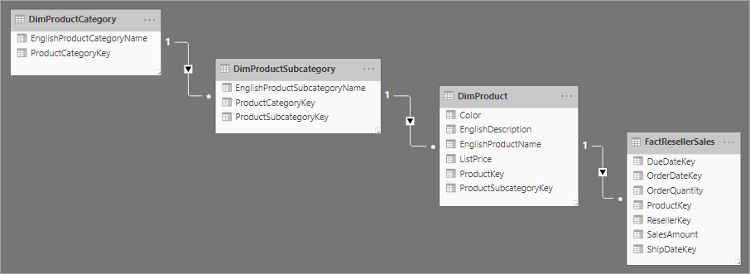
- Star schema
    - The image depicts a schema where a central fact table is connected to multiple dimension tables in a star-like structure. 
    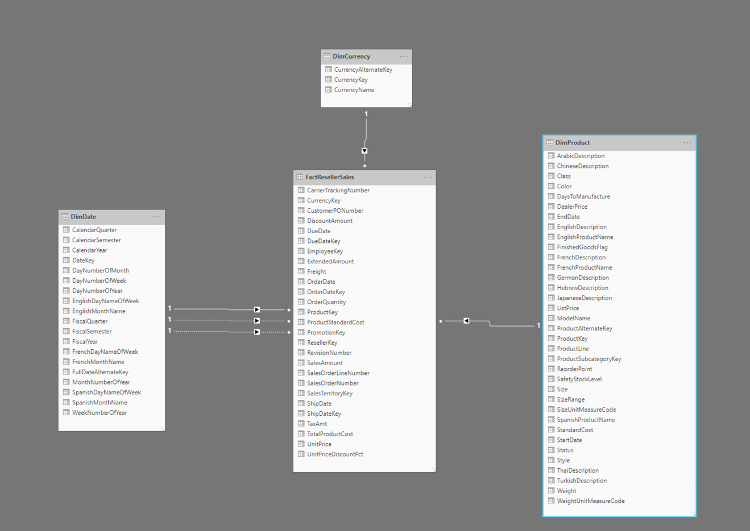
- Ring schema
    - tables are connected in a circular manner
    -  not commonly used in data warehousing and are more complex in terms of data retrieval and maintenance.



###  Azure Resource Manager template 

- dependsOn
    -  allows you to define dependencies between different resources. This ensures that resources are deployed in the correct order, based on their dependencies, to avoid any deployment issues or errors.
- variables
    -  used to define variables that can be referenced throughout the template.
- resource
    - used to define the actual Azure resources that will be deployed within the specified Azure Resource Group
- collation
    - used to specify the collation settings for a database resource. It determines how data is sorted and compared in the database

### Azure open source database platforms
- Each of these services comes with native high availability, automatic patching, automatic backups and the highest level of security protection. 
1. Azure Database for PostgreSQL database backups

- Azure Database for PostgreSQL database backups can only be restored to Azure Database for PostgreSQL instances. the backup format and structure are specific and cannot be directly restored to other platforms, e.g. postgresql.
- The cost for backup storage for Azure Database for PostgreSQL is free up to the size of the database. This means that as long as the backup storage does not exceed the size of the database, there will be no additional cost incurred for storing backups.
- Deployment for MariaDB, MySQL, and PostgreSQL on Azure is supported using standard Azure methods such as the Azure portal, PowerShell, Azure Resource Manager templates, and the Azure CLI. 
- support  Microsoft Entra ID authentication
- supports a maximum storage size of 4 TB for full and differential backups, and up to 16 TB for snapshot backups. 

2. Azure Database for MySQL
- upgrade can be managed from within the Upgrade tab of the Azure Portal without any data loss
- Creating a dump of the database and restoring it to a server at a higher version, ensures that the data is preserved during the upgrade process.
- support  Microsoft Entra ID authentication
- Connection resiliency is crucial for handling transient errors in a mission-critical MySQL database. it can automatically retry failed connections, recover from network interruptions, and maintain a stable connection to the database, thus ensuring low latency and uninterrupted service.
- High availability comes packaged in with the service with extra cost. Transactions on either platform are written synchronously to storage. If a node interruption occurs, the database server will automatically create a new node and subsequently attach the storage to the new node. Any transactions in flight are not committed and active connections to the database are dropped.

3. Azure Database for MariaDB
- High availability comes packaged in with the service with extra cost. Transactions on either platform are written synchronously to storage. If a node interruption occurs, the database server will automatically create a new node and subsequently attach the storage to the new node. Any transactions in flight are not committed and active connections to the database are dropped.

**note: ultra ssd** Ultra SSD provides the highest level of performance and throughput among the Azure storage options. It is designed for high-performance workloads and is best suited for production data files that require maximum throughput.
offers the lowest latency, even faster than Premium SSD



# practice test 4

### network option for azure sql db & mi
- Private endpoint provides secure access to the database within a virtual network, which is necessary for scenarios where secure access within a designated network is required.
- Public endpoint allows the database to be accessed externally over the internet, which is necessary for certain scenarios where public access to the database is required.
- Azure SQL db by default has a public internet endpoint, But no access is possible until firewall rules or “allow Azure services” is enabled
- Azure SQL mi has No public endpoint at all (lives inside a VNet), Default = private only.


- The default connection policy for Azure SQL Database and Azure SQL Managed Instance is to use a proxy for connections outside of Azure and redirect for connections within Azure. 
- network Access (firewall / VNet rules) – Can you even reach the server?
- Connection Policy (proxy/redirect) – If access is granted, how does Azure route the traffic?
### index principal
- A table that is used mainly for insert operations will benefit far less from additional indexes than a table used for data warehouse operations that are 90% read activity.

-  Indexes are ideal for integer data types, or unique or non-null columns.
- Create nonclustered indexes on columns that are frequently used in predicates and join clauses, and keep those indexes as narrow as possible to avoid overhead.
-  A table scan on a small table will be a relatively cheap operation and SQL may decide to do a table scan simply because it is easy (trivial) to do. A table scan on a very large table would be very costly.

**note Parameter sniffing** refers to a SQL Server optimization process where the initial parameter values passed to a stored procedure are used to generate an execution plan. 

### SARG

- Predicates (WHERE clause) in the correct format are called ‘Search Arguments’ or SARGs. 
- In SQL Server, using a SARG means that the optimizer will evaluate using a nonclustered index on the column referenced in the SARG for a SEEK operation, instead of scanning the entire index (or the entire table) to retrieve a value.

- The presence of a SARG does not guarantee the use of an index for a SEEK
- if a SARG refers to a large percentage of rows in a table, costing algorithms could still determine that the index was too expensive
- The absence of a SARG mean that the optimizer will not even evaluate a SEEK on a nonclustered index.

-  examples of  non-sargable
    - WHERE lastName LIKE ‘%SMITH%’
    - when using functions on a column, for example, WHERE CONVERT(CHAR(10), CreateDate,121) = ‘2020-03-22’.

**note tempdb** SQL Server uses tempdb for various purposes, including storing user-defined temporary tables, work tables for intermediate query results, sorting operations, and the version store for row versioning. It is crucial to place tempdb on the lowest latency storage possible and configure its data files properly to ensure optimal performance.

### command line interface

- Popular command-line interfaces like sqlcmd and bcp are supported with Azure SQL services.
    - "bcp" stands for bulk copy program and is used to import and export large amounts of data in and out of SQL Server databases.
    - sqlcmd is a command-line utility for SQL Server
- Azure CLI and Azure PowerShell cmdlets are supported for specific Azure SQL service scenarios. All these CLIs are supported across Windows, macOS, and Linux clients. Tools like sqlcmd and az are pre-installed in Azure Cloud Shell.



# practice test 5 & practice test 6

### Azure Storage
- Storage performance is a critical component of an I/O heavy application like a database engine.
1.  Disk Storage 
    - Azure managed disks offer block storage that is presented to a virtual machine. 
    - These disks are managed just like a physical disk in an on-premises server, except that they are virtualized. 
    - There are several performance tiers
    - most commonly used type for SQL Server data and transaction log files.
2. Blob Storage 
    - object-based storage and includes cold, hot, and archive storage tiers. 
    - In a SQL Server environment, blob storage will typically be used for database backups, using SQL Server’s back up to URL functionality.
3. ile Storage 
    - a file share that can be mounted inside a virtual machine, without the need to set up any hardware. 
    - SQL Server can use File storage as a storage target for a failover cluster instance.
### Database normalization 
- a technique used in database design to organize tables and attributes in a structured way to reduce redundancy and improve data integrity. 
- By eliminating redundant data and organizing data into logical groupings, normalization helps to ensure data consistency and minimize the risk of anomalies.

- Data denormalization is a technique used on a previously-normalized database to increase performance by reducing the number of joins needed to retrieve data, which can improve query performance.
**note chaining** allows the user to inherit access rights to the table during the execution of the stored procedure, but only within the scope of that specific execution context.

### load balancer

1. Public load balancers are typically used for routing incoming traffic from the internet to backend services in Azure
2. Enhanced load balancers offer additional features and performance improvements
3. Private load balancers are used for internal communication within a virtual network in Azure
4. Standard load balancer offers more features and capabilities compared to other options, making it the most suitable choice for ensuring high availability and fault tolerance in multi-zone deployments
5. Basic load balancers in Azure offer limited functionality 

### server-level action group
- Azure SQL auditing tracks database events and writes them to an audit log in your Azure Storage account, Log Analytics workspace or Event Hubs
1. BATCH_STARTED_GROUP is not the suitable choice for auditing queries and stored procedures executed against the database. This action group captures events related to the start of batch commands
2. BATCH_COMPLETED_GROUP is the correct choice for auditing queries and stored procedures executed against the database. This action group captures events related to the completion of batch commands,
3. SENSITIVE_BATCH_COMPLETED_GROUP is specifically designed to capture sensitive batch commands, 
4. DATABASE_AUTHENTICATION_GROUP is focused on capturing events related to database authentication activities, such as logins and logouts

**note The Storage Engine** is the SQL Server component responsible for managing the data storage within the database files. It uses the Proportional Fill Algorithm to write data to the database files based on the amount of free space in each file, rather than filling one file completely before moving to the next one.



### SAS
-  stands for Shared Access Signature
-  used to grant limited rights to resources in an Azure storage account for a specified time period. 
- enables applications to access resources such as blobs and files without requiring authentication first.
-  should only use SAS for data that you intend to make public.

**note DML** data manipulation language (DML) operations. These permissions are SELECT, INSERT, UPDATE, and DELETE

**note DDL** Data Definition Language CREATE , ALTER, DROP, TRUNCATE, COMMENT, RENAME 

**note express route**  It is a private, dedicated connection between on-premises infrastructure and Azure data centers. tends to be more costly, it also provides the best security and lowest latency as all communication flows over a direct secured channel independent of the public internet. However, common detractors for this solution include overall cost and the inability to apply express route between cloud providers in a multicloud solution.

**note Azure Pipelines** is a fully featured CI/CD service in Azure DevOps that allows for automating the build, testing, and deployment of code. It is the correct choice for carrying out deployments in Azure DevOps.

# practice test 7

### Azure IoT Edge module
- In Azure IoT (Internet of Things) Edge, a module is essentially a containerized application (usually Docker containers) that runs on your IoT Edge device.
    - A built-in Azure service (like Stream Analytics, Azure Functions, Machine Learning models).
    
    **note  Azure Functions** are Azure services that enable serverless workloads. These services allow users to create workflows consisting of multiple steps to automate complex tasks
    - A custom module you develop (in C#, Python, Node.js, etc.).

- Each module runs in its own container, deployed and managed through the IoT Edge runtime.
1. Hybrid semi-connected a scenario where the IoT Edge modules have intermittent internet connectivity, switching between connected and disconnected states. This state allows for data transfer and communication with the Azure SQL Edge database during periods of connectivity.

2. Disconnected have lost internet connectivity, preventing data transfer and communication with the Azure SQL Edge database. This state is crucial for handling intermittent internet connectivity issues
3. Connected IoT Edge modules have a stable and continuous internet connection, allowing seamless data transfer and communication 

### Azure Resource Manager templates
-  have the benefit of being able to deploy a full set of resources in one single declarative template
- component: 
    - parameter allows you to specify the region for a resource group deployment. such as the region where the resources will be provisioned.
- framework:
    - imperative frameworks, such as PowerShell and Azure CLI, follow a specific order of tasks to be executed, providing step-by-step instructions for the system to follow
    - Declarative frameworks focus on specifying the desired outcome or end result
    - Generative frameworks focus on automatically generating code or configurations based on certain rules or patterns

###  Azure preview features
- Azure is constantly evolving, and new features are released continuously. It may take some time before new features are generally available through the preview process. While preview features can benefit your applications, there are some tradeoffs around supportability.

    1.  Alpha category is the earliest stage of testing for new features, where they are still in development and may not be fully functional or stable. Alpha features are typically limited to a small group of users for initial testing and feedback. They are not recommended for production use and may undergo significant changes before reaching a more advanced preview stage.

    2. Private preview features will require that Microsoft add your subscription to an allowlist for a given feature. During this phase we invite a few customers to take part in early access to new concepts and features. This phase does not include formal support.

    3. Beta category typically refers to features that are in a more advanced stage of testing  Beta features may still be undergoing testing and refinement before they are officially launched. They are usually accessible to a broader audience than private previews but may not be as widely available as public previews.

    4. Public preview features are opted into in the portal but are available to any customer with the proper Microsoft Entra ID license. Some features may require further opt-in at the individual resource. The public preview experience isn't consistent across Azure services. normal service level agreements do not apply. 

    5. Generally available (GA) – After the public preview is completed, the feature is open for any licensed customer to use and is supported via all Microsoft support channels. Be aware when a new feature impacts existing functionality,

**note SQL Server Resource Provider** for Azure VMs includes options for configuring storage settings related to SQL Server databases running on Azure VMs. This includes settings for data and log file storage, as well as storage performance configurations.

### Process for developing solutions

1. Discovery: The original statement of the problem from the customer.

2. Envisioning: A "blue sky" description of what success in the project would look like. It's often phrased as "I can..." statements.

3. Architecture design session: An initial layout of the technology options and choices for a preliminary solution.

4. Proof of concept (POC): After the optimal technologies and processes are selected for the solution, a POC is set up with a small representative example of what a solution might look like. If a currently running solution in a parallel example is available, you can use that.

5. Implementation: Implementing a phased-in rollout of the completed solution based on findings from the previous phases.

6. Handoff: A postmortem on the project with a discussion of future enhancements.

### conversion type
- implicit conversion SQL Server can convert some data types automatically , conversion can be costly and can also negatively impact query plans. still perform better than explicit 
- explicit conversion, where you use the CAST or CONVERT function in your code to force a data type conversion.  This type of conversion is directly specified by the user and can be costly in terms of performance, as it requires additional processing to convert the data types.

###  disk types

1. Standard HDD was the original storage offering on Azure and offers cost-effective storage for non-I/O intensive workloads. A common use case for standard disks is for SQL Server backups.

2. Standard SSD is a solid-state drive and will have similar latency and IOPS to the standard HDD drives at sizes up to 4 TB; however, this type offers significant performance gains at larger volumes. Standard SSDs do offer guaranteed performance levels where the Standard HDD disks do not.

3. Premium SSD is the most commonly used type of disk for SQL Server workloads. They are available in all regions and support a wide variety of VM types. Premium disks strike a good balance between price and performance.

4. Ultra SSD provides the lowest latency (submillisecond) and the highest potential IOPs. Ultra SSD allows you to configure IOPs, storage volume, and bandwidth independently for more granular cost control.

**note Skip Target** In the Proportional Fill Algorithm, each database data file will be assigned with a ranking integer number to specify how many times this file will be skipped from the writing process to the next file depending on the free space of that file, where the minimum value equal to 1 means that a write process will be performed on that file.

**note Lightweight Profiling** Lightweight Profiling was introduced by Microsoft starting with SQL Server 2014 SP2 and enhanced with SQL Server 2016 SP1 and all later versions. It provides a less resource-intensive way to capture actual execution plans compared to traditional methods, making it a more efficient option for live site troubleshooting efforts.

**note a schema** is a collection of objects within a database that allows for the grouping of objects into separate namespaces. This helps in organizing and managing database objects effectively. Additionally, every user has a default schema that determines the namespace in which their objects reside.

###  Logic Apps
 - Azure services that enable serverless workloads. These services allow users to create workflows consisting of multiple steps to automate complex tasks
    - Schedule and send email notifications using Office 365 when a specific event happens, for example, a new file is uploaded.

    - Route and process customer orders across on-premises systems and cloud services.

    - Move uploaded files from an SFTP or FTP server to Azure Storage.

    - Monitor tweets, analyze the sentiment, and create alerts or tasks for items that need review.

**note transaction atomicity**, which ensures that all changes made by a transaction are either fully applied or fully rolled back. 

**note breakpoint** in a program where execution is paused for debugging purposes.

**note Database Collation** refers to the set of rules that determine how data is sorted and compared in a database. It includes character set, sort order, and case sensitivity settings that affect how data is stored and retrieved.

### wait types 
-  reasons why a session is waiting
    - RESOURCE_SEMAPHORE: a task is waiting for a query execution memory grant.
    - PAGEIOLATCH_SH: a task is waiting for a page to be read from disk into the buffer cache
    - SOS_SCHEDULER_YIELd:  wait type indicates that a task is waiting for the scheduler to yield the processor. This can occur when there is excessive CPU consumption, causing tasks to wait for CPU resources to become available.
    - SHOWPLAN_EXL: wait type indicates that a task is waiting for the query plan to be generated.

**note: Accelerated Database Recovery** is a feature built into the Azure SQL Database engine. It helps in truncating the transaction log aggressively and using a persisted version store, which enables instant transaction rollback and quick database recovery, addressing issues related to long-running transactions.

**note policy** provides a level of governance over your Azure Subscriptions which enforce rules and controls over your Azure resources.

### deploying a hybrid SQL solution
- all core infrastructure, such as Active Directory and DNS, must exist on-premises and in Azure. 
- In addition, secure two-way communication must exist between the on-premises network and Azure. 
    - site-to-site (S2S) VPN :  It allows for encrypted communication between the environments, enabling data transfer and access control.
    - dedicated ExpressRoute tunnel:  private connection between an on-premises network and Azure, offering a dedicated, high-throughput connection with lower latency compared to public internet connections.

- When evaluating different connectivity methods, it's vital to determine the amount of latency acceptable for your organization.

**note  batching** with appropriately sized batches can help optimize data loading by breaking down large data sets into smaller, manageable chunks. This approach can reduce resource contention, improve throughput, and prevent timeouts during the data loading process

**note deployment check** it's a good practice to review the deployment details and activity log to ensure there were no failures or active issues.

For Azure SQL Managed Instance, you then might check the error log, which is a common thing to do in SQL Server on-premises or in an Azure VM. This capability is not available in Azure SQL Database.


